In [ ]:
!nvidia-smi

Wed Apr 20 13:37:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import preprocessing
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import preprocessing

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from pandas import DataFrame
from pandas import concat
import tensorflow as tf

from tensorflow import keras
import time
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]
from google.colab import output as out

#Load Dataset

In [ ]:
csv_path = "data00-21.csv"
df = pd.read_csv(csv_path, parse_dates=['DATE'], index_col='DATE')
df.drop(['NAME', 'LATITUDE', 'LONGITUDE', 'STP', 'VISIB'], axis=1, inplace=True)
df

,PRCP,DEWP,MAX,MIN,MXSPD,SLP,TEMP,WDSP
DATE,,,,,,,,
2000-01-01,0.00,74.9,92.8,75.0,9.9,1006.4,83.3,3.6
2000-01-02,99.99,74.2,91.4,75.2,15.0,9999.9,81.1,4.5
2000-01-03,99.99,72.9,84.2,73.4,8.9,9999.9,78.8,5.6
2000-01-04,99.99,74.3,87.8,75.2,8.0,9999.9,82.1,2.8
2000-01-05,0.00,75.6,89.6,75.9,6.0,1008.1,83.3,2.1
...,...,...,...,...,...,...,...,...
2021-07-03,0.00,73.6,90.0,75.2,6.0,1009.8,81.2,3.9
2021-07-04,0.00,72.7,90.0,73.8,11.1,1010.0,82.5,5.4
2021-07-05,0.00,71.4,91.4,74.8,15.9,1008.9,81.5,6.0


In [ ]:
# Konversi F ke C
def FtoC(valF):
     return (valF - 32) * 5/9 
    
def InchToMm(valInch):
    return valInch*25.4

perluKonversi = ['DEWP', 'MIN', 'MAX', 'TEMP', 'PRCP']
for i in perluKonversi:
    if i == 'PRCP':
        df[i] = df.apply(lambda row : InchToMm(row[i]), axis = 1)    
    else:
        df[i] = df.apply(lambda row : FtoC(row[i]), axis = 1)
df.head()

,PRCP,DEWP,MAX,MIN,MXSPD,SLP,TEMP,WDSP
DATE,,,,,,,,
2000-01-01,0.000,23.833333,33.777778,23.888889,9.9,1006.4,28.500000,3.6
2000-01-02,2539.746,23.444444,33.000000,24.000000,15.0,9999.9,27.277778,4.5
2000-01-03,2539.746,22.722222,29.000000,23.000000,8.9,9999.9,26.000000,5.6
2000-01-04,2539.746,23.500000,31.000000,24.000000,8.0,9999.9,27.833333,2.8
2000-01-05,0.000,24.222222,32.000000,24.388889,6.0,1008.1,28.500000,2.1


#Plot sebelum Filter

IndexError: ignored

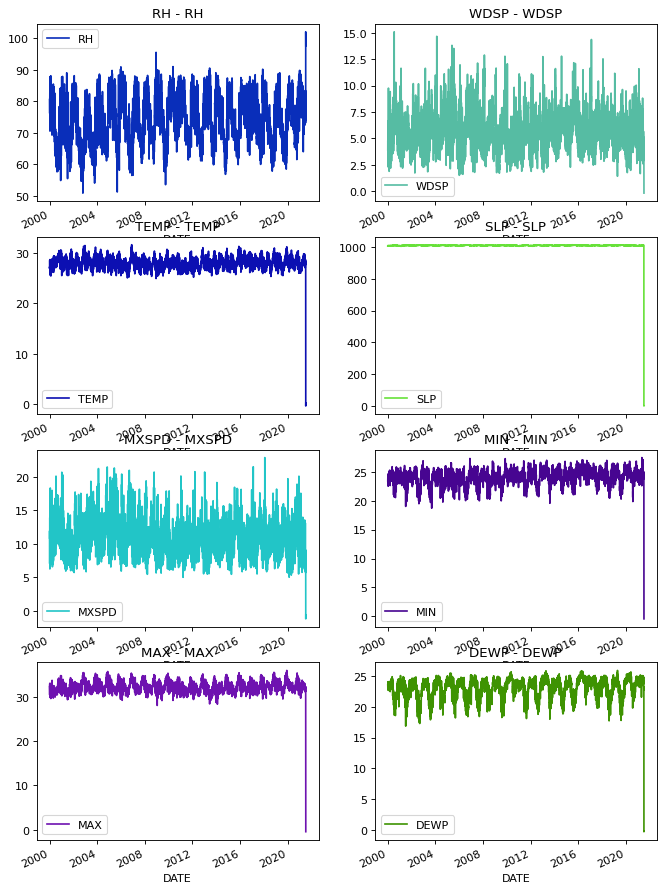

In [ ]:
import random

def show_raw_visualization(data, rows=4):
    titles = list(data)
    feature_keys = list(data)
    #time_data = data[date_time_key]
    time_data = data.index
    fig, axes = plt.subplots(
        nrows=rows, ncols=2, figsize=(10, 15), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = random.random(), random.random(), random.random()
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()
show_raw_visualization(df, rows=4)

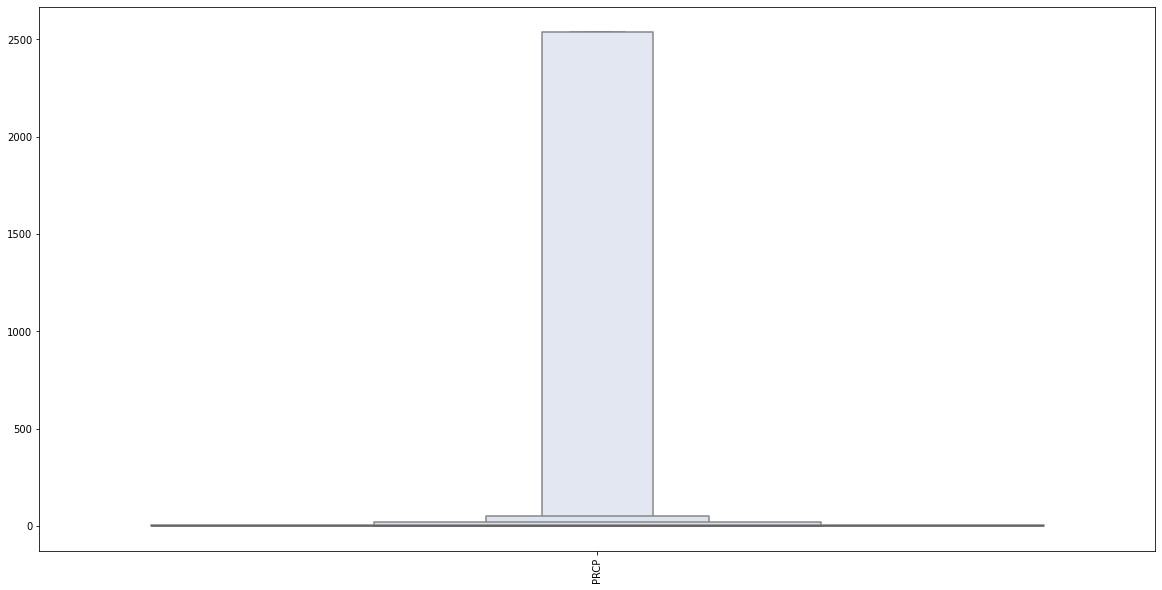

In [ ]:
features = df

#Set up a standard scaler for the features
col_names = list(features.columns)
s_scaler = preprocessing.StandardScaler()
features = s_scaler.fit_transform(features)
features = pd.DataFrame(features, columns=col_names) 

#outlier
colours = ["#D0DBEE", "#C2C4E2", "#EED4E5", "#D1E6DC", "#BDE2E2"]
plt.figure(figsize=(20,10))
sns.boxenplot(data = df[['PRCP']],palette = colours)
plt.xticks(rotation=90)
plt.show()

#Filter

In [ ]:
#memberikan nilai NaN pada data outlier jika data di atas threshold
def FilterSLP(val):
    if val < 1004 or val > 1015:
        val = np.NaN
    return val

def FilterPRCP(val):
    if val > 2539:
        val = np.NaN
    return val

def FilterMin(val):
    if val < 19 or val > 28:
        val = np.NaN
    return val

def FilterMax(val):
    if val < 27.5 or val > 36:
        val = np.NaN
    return val

def FilterTemp(val):
    if val < 24.5 or val > 100:
        val = np.NaN
    return val

def FilterDewp(val):
    if val < 17 or val > 100:
        val = np.NaN
    return val

def FilterMXSPD(val):
    if val > 25 or val < 5:
        val = np.NaN
    return val

def FilterWDSP(val):
    if val > 15:
        val = np.NaN
    return val

df['SLP'] = df.apply(lambda row : FilterSLP(row['SLP']), axis = 1)
# df['PRCP'] = df.apply(lambda row : FilterPRCP(row['PRCP']), axis = 1)
df['MIN'] = df.apply(lambda row : FilterMin(row['MIN']), axis = 1)
df['MAX'] = df.apply(lambda row : FilterMax(row['MAX']), axis = 1)
df['TEMP'] = df.apply(lambda row : FilterTemp(row['TEMP']), axis = 1)
df['DEWP'] = df.apply(lambda row : FilterDewp(row['DEWP']), axis = 1)
df['MXSPD'] = df.apply(lambda row : FilterMXSPD(row['MXSPD']), axis = 1)
df['WDSP'] = df.apply(lambda row : FilterWDSP(row['WDSP']), axis = 1)

In [ ]:
df.isnull().sum()

RH          0
WDSP        1
TEMP        3
SLP         3
MXSPD       4
MIN         5
MAX         3
DEWP        4
MONTH_1     0
MONTH_2     0
MONTH_3     0
MONTH_4     0
MONTH_5     0
MONTH_6     0
MONTH_7     0
MONTH_8     0
MONTH_9     0
MONTH_10    0
MONTH_11    0
MONTH_12    0
RAINT_0     0
RAINT_1     0
dtype: int64

#Interpolasi Mean waktu yg sama

In [ ]:
#resample rata-rata di hari dan bulan yg sama pada semua tahun
df1 = df.groupby([df.index.month, df.index.day], as_index=True).mean()
df1

RH  WDSP   TEMP      SLP  MXSPD    MIN    MAX   DEWP  MONTH_1  \
DATE DATE                                                                     
1    1     79.86  5.19  27.61  1008.79  10.69  24.63  32.25  23.86      1.0   
     2     78.98  5.52  27.70  1008.84  10.89  24.59  32.34  23.78      1.0   
     3     78.83  5.25  27.67  1008.89  10.32  24.35  32.25  23.70      1.0   
     4     80.03  4.78  27.47  1008.92   9.92  24.10  32.04  23.74      1.0   
     5     79.86  4.83  27.53  1008.86  10.22  24.12  32.20  23.77      1.0   
...          ...   ...    ...      ...    ...    ...    ...    ...      ...   
12   27    78.58  5.67  27.82  1008.31  11.04  24.42  32.53  23.80      0.0   
     28    77.91  5.32  27.98  1008.40  10.50  24.50  32.42  23.80      0.0   
     29    77.84  5.24  27.91  1008.61  10.51  24.64  32.32  23.73      0.0   
     30    78.85  5.36  27.79  1008.45  11.11  24.69  32.15  23.82      0.0   
     31    78.91  5.53  27.80  1008.51  11.26  24.81  32.22  23.84      0.0   

           MONTH_2  ...  MONTH_5  MONTH_6  MONTH_7  MONTH_8  MONTH_9  \
DATE DATE           ...                                                
1    1         0.0  ...      0.0      0.0      0.0      0.0      0.0   
     2         0.0  ...      0.0      0.0      0.0      0.0      0.0   
     3         0.0  ...      0.0      0.0      0.0      0.0      0.0   
     4         0.0  ...      0.0      0.0      0.0      0.0      0.0   
     5         0.0  ...      0.0      0.0      0.0      0.0      0.0   
...            ...  ...      ...      ...      ...      ...      ...   
12   27        0.0  ...      0.0      0.0      0.0      0.0      0.0   
     28        0.0  ...      0.0      0.0      0.0      0.0      0.0   
     29        0.0  ...      0.0      0.0      0.0      0.0      0.0   
     30        0.0  ...      0.0      0.0      0.0      0.0      0.0   
     31        0.0  ...      0.0      0.0      0.0      0.0      0.0   

           MONTH_10  MONTH_11  MONTH_12  RAINT_0  RAINT_1  
DATE DATE                                                  
1    1          0.0       0.0       0.0     0.19     0.81  
     2          0.0       0.0       0.0     0.14     0.86  
     3          0.0       0.0       0.0     0.18     0.82  
     4          0.0       0.0       0.0     0.14     0.86  
     5          0.0       0.0       0.0     0.18     0.82  
...             ...       ...       ...      ...      ...  
12   27         0.0       0.0       1.0     0.20     0.80  
     28         0.0       0.0       1.0     0.33     0.67  
     29         0.0       0.0       1.0     0.40     0.60  
     30         0.0       0.0       1.0     0.33     0.67  
     31         0.0       0.0       1.0     0.38     0.62  

[366 rows x 22 columns]

In [ ]:
#mengisikan rata2 pada tanggal dan bulan yg sama pada nilai NaN
for kolom in list(df):
    index = df.index[df[kolom].apply(np.isnan)]
    print(kolom)
    for num, val in enumerate(index):
        df.loc[val, kolom] = df1.loc[index.month[num], index.day[num]][kolom]

RH
WDSP
TEMP
SLP
MXSPD
MIN
MAX
DEWP
MONTH_1
MONTH_2
MONTH_3
MONTH_4
MONTH_5
MONTH_6
MONTH_7
MONTH_8
MONTH_9
MONTH_10
MONTH_11
MONTH_12
RAINT_0
RAINT_1


#Filter FFT

In [ ]:
df

,PRCP,DEWP,MAX,MIN,MXSPD,SLP,TEMP,WDSP
DATE,,,,,,,,
2000-01-01,0.000000,23.833333,33.777778,23.888889,9.9,1006.400000,28.500000,3.6
2000-01-02,5.948947,23.444444,33.000000,24.000000,15.0,1009.010000,27.277778,4.5
2000-01-03,15.024100,22.722222,29.000000,23.000000,8.9,1008.850000,26.000000,5.6
2000-01-04,11.817048,23.500000,31.000000,24.000000,8.0,1008.852381,27.833333,2.8
2000-01-05,0.000000,24.222222,32.000000,24.388889,6.0,1008.100000,28.500000,2.1
...,...,...,...,...,...,...,...,...
2021-07-03,0.000000,23.111111,32.222222,24.000000,6.0,1009.800000,27.333333,3.9
2021-07-04,0.000000,22.611111,32.222222,23.222222,11.1,1010.000000,28.055556,5.4
2021-07-05,0.000000,21.888889,33.000000,23.777778,15.9,1008.900000,27.500000,6.0


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def fft_filter(signal, N=8, M=2):

    """
    Implementation of Fourier filter.
    Takes a signal and filter parameters and return the filtered signal.
    input:
        - signal: signal to be filtered
        - N: window size of input signal
        - M: samples of fft signal to preserve (remember fft symmetry)
    output:
        - filtered signal
    """

    predicted_signal = []

    for j in range(0, np.shape(signal)[0], N):      # iterates on the entire signal, taking steps by N (window size)

        N = np.minimum(N, np.shape(signal)[0] - j)  # just in case we are at signal final and N samples are not avail

        R_0 = np.zeros(N)
        R_0[:] = signal[j:j+N]                       # saves in R_0 signal values of corresponding window size

        R_0_fft = np.fft.fft(R_0)                    # fft of signal window

        for k in range(int(N / 2)):                    # it keeps M samples of fft and sets the rest to zero
            R_0_fft[M+k] = 0                         # remember fft symmetry
            R_0_fft[-1-M-k] = 0

        R_0_ifft = np.fft.ifft(R_0_fft)              # inverse fft

        for i in range(0, N):
            predicted_signal.append(R_0_ifft[i].real)     # update predicted signal with this window calculation

    return predicted_signal

In [ ]:
for i in df.columns:
  df[i] = fft_filter(df[i], N=8, M=2)

In [ ]:
df

,PRCP,DEWP,MAX,MIN,MXSPD,SLP,TEMP,WDSP
DATE,,,,,,,,
2000-01-01,1.183406,23.526297,32.285335,23.417978,10.855330,1007.827971,27.081683,3.899264
2000-01-02,3.260533,23.303581,32.065003,23.696334,11.925584,1008.273490,27.229371,4.772640
2000-01-03,12.873413,23.088593,30.603553,23.543147,10.355330,1008.930069,26.872702,4.687132
2000-01-04,6.194583,23.468852,30.436463,23.873111,7.046725,1008.795721,27.507149,3.392310
2000-01-05,3.258093,24.015369,32.103553,24.512578,7.844670,1008.162625,28.515539,2.300736
...,...,...,...,...,...,...,...,...
2021-07-03,-1.920087,22.705781,31.970742,23.756077,6.853249,1009.917157,27.656641,3.941269
2021-07-04,0.000000,23.196334,32.213593,23.881246,9.050000,1010.108579,28.076593,5.098376
2021-07-05,0.000000,0.361111,0.037037,0.527778,1.800000,-0.283333,0.092593,0.300000


#Penurunan Fitur

In [ ]:
#Penurunan fitur
def getRH(valT, valDp):
    T = valT + 273.15
    Td = valDp + 273.15
    L = 2.501*10**6
    Rw = 461.5
    RH = np.exp((-T/Td+1) * L / (T*Rw))
    return RH*100
df['RH'] = df.apply(lambda row : getRH(row['TEMP'], row['DEWP']), axis = 1)

#ekstrak bulan
df['MONTH'] = df.index.month

#rain category
def RainCat(valMm):
    if valMm >= 0.5:
        return 1 
    elif valMm < 0.5:
        return 0 
df['RAINTODAY'] = df.apply(lambda row : RainCat(row['PRCP']), axis = 1)

df.dropna(inplace=True)
df = df[df.columns[::-1]]
df

,RAINTODAY,MONTH,RH,WDSP,TEMP,SLP,MXSPD,MIN,MAX,DEWP,PRCP
DATE,,,,,,,,,,,
2000-01-01,1,1,80.548043,3.899264,27.081683,1007.827971,10.855330,23.417978,32.285335,23.526297,1.183406
2000-01-02,1,1,78.748234,4.772640,27.229371,1008.273490,11.925584,23.696334,32.065003,23.303581,3.260533
2000-01-03,1,1,79.395136,4.687132,26.872702,1008.930069,10.355330,23.543147,30.603553,23.088593,12.873413
2000-01-04,1,1,78.239357,3.392310,27.507149,1008.795721,7.046725,23.873111,30.436463,23.468852,6.194583
2000-01-05,1,1,76.181702,2.300736,28.515539,1008.162625,7.844670,24.512578,32.103553,24.015369,3.258093
...,...,...,...,...,...,...,...,...,...,...,...
2021-07-03,0,7,73.972433,3.941269,27.656641,1009.917157,6.853249,23.756077,31.970742,22.705781,-1.920087
2021-07-04,0,7,74.358443,5.098376,28.076593,1010.108579,9.050000,23.881246,32.213593,23.196334,0.000000
2021-07-05,0,7,101.966201,0.300000,0.092593,-0.283333,1.800000,0.527778,0.037037,0.361111,0.000000


In [ ]:
# Correlation amongst numeric attributes
corrmat = df.corr(method='pearson')
cmap = sns.diverging_palette(260,-10,s=50, l=75, n=6, as_cmap=True)
plt.subplots(figsize=(14,14))
sns.heatmap(corrmat,cmap= cmap,annot=True, square=True)

#ONE HOT ENCODING

In [ ]:
month = pd.get_dummies(df['MONTH'], prefix='MONTH')
raint = pd.get_dummies(df['RAINTODAY'], prefix='RAINT')
df.drop(['RAINTODAY', 'MONTH', 'PRCP'], axis=1, inplace=True)
df = df.join(month)
df = df.join(raint)
df.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,RH,WDSP,TEMP,SLP,MXSPD,MIN,MAX,DEWP,MONTH_1,MONTH_2,...,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,RAINT_0,RAINT_1
DATE,,,,,,,,,,,,,,,,,,,,,
2000-01-01,80.548043,3.899264,27.081683,1007.827971,10.855330,23.417978,32.285335,23.526297,1,0,...,0,0,0,0,0,0,0,0,0,1
2000-01-02,78.748234,4.772640,27.229371,1008.273490,11.925584,23.696334,32.065003,23.303581,1,0,...,0,0,0,0,0,0,0,0,0,1
2000-01-03,79.395136,4.687132,26.872702,1008.930069,10.355330,23.543147,30.603553,23.088593,1,0,...,0,0,0,0,0,0,0,0,0,1
2000-01-04,78.239357,3.392310,27.507149,1008.795721,7.046725,23.873111,30.436463,23.468852,1,0,...,0,0,0,0,0,0,0,0,0,1
2000-01-05,76.181702,2.300736,28.515539,1008.162625,7.844670,24.512578,32.103553,24.015369,1,0,...,0,0,0,0,0,0,0,0,0,1


#Multivariate GRU

In [ ]:
batchSize = 128
splitter = 0.9
gruUnits = 128
denseUnits = 64

#lag = 1 #banyak observasi hari sebelumnya
lag = 2 #banyak observasi hari sebelumnya
#lag = 14 #banyak observasi hari sebelumnya
#lag = 14 #banyak observasi hari sebelumnya

In [ ]:
df.head()

,RH,WDSP,TEMP,SLP,MXSPD,MIN,MAX,DEWP,MONTH_1,MONTH_2,...,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,RAINT_0,RAINT_1
DATE,,,,,,,,,,,,,,,,,,,,,
2000-01-01,75.404622,3.6,28.500000,1006.400000,9.9,23.888889,33.777778,23.833333,1,0,...,0,0,0,0,0,0,0,0,0,1
2000-01-02,79.204324,4.5,27.277778,1009.010000,15.0,24.000000,33.000000,23.444444,1,0,...,0,0,0,0,0,0,0,0,0,1
2000-01-03,81.816506,5.6,26.000000,1008.850000,8.9,23.000000,29.000000,22.722222,1,0,...,0,0,0,0,0,0,0,0,0,1
2000-01-04,76.873187,2.8,27.833333,1008.852381,8.0,24.000000,31.000000,23.500000,1,0,...,0,0,0,0,0,0,0,0,0,1
2000-01-05,77.225686,2.1,28.500000,1008.100000,6.0,24.388889,32.000000,24.222222,1,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
n_train_days = int(len(df)*splitter)
dfTrain = df.iloc[:n_train_days, :]
dfTest = df.iloc[n_train_days:, :]

print(dfTrain.index[0], dfTrain.index[-1])
print(dfTest.index[0], dfTest.index[-1])
dfTrain

2000-01-01 00:00:00 2019-05-15 00:00:00
2019-05-16 00:00:00 2021-07-07 00:00:00


,RH,WDSP,TEMP,SLP,MXSPD,MIN,MAX,DEWP,MONTH_1,MONTH_2,...,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,RAINT_0,RAINT_1
DATE,,,,,,,,,,,,,,,,,,,,,
2000-01-01,75.404622,3.6,28.500000,1006.400000,9.9,23.888889,33.777778,23.833333,1,0,...,0,0,0,0,0,0,0,0,0,1
2000-01-02,79.204324,4.5,27.277778,1009.010000,15.0,24.000000,33.000000,23.444444,1,0,...,0,0,0,0,0,0,0,0,0,1
2000-01-03,81.816506,5.6,26.000000,1008.850000,8.9,23.000000,29.000000,22.722222,1,0,...,0,0,0,0,0,0,0,0,0,1
2000-01-04,76.873187,2.8,27.833333,1008.852381,8.0,24.000000,31.000000,23.500000,1,0,...,0,0,0,0,0,0,0,0,0,1
2000-01-05,77.225686,2.1,28.500000,1008.100000,6.0,24.388889,32.000000,24.222222,1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-11,73.178932,4.0,28.888889,1011.600000,11.1,25.000000,32.388889,23.722222,0,0,...,1,0,0,0,0,0,0,0,1,0
2019-05-12,70.905293,5.0,28.555556,1011.100000,8.9,24.888889,32.388889,22.888889,0,0,...,1,0,0,0,0,0,0,0,1,0
2019-05-13,72.946405,5.2,29.000000,1010.600000,9.9,24.388889,32.722222,23.777778,0,0,...,1,0,0,0,0,0,0,0,1,0


In [ ]:
valuesTrain = dfTrain.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaledTrain = scaler.fit_transform(valuesTrain)
valuesTest = dfTest.astype('float32')
scaledTest = scaler.transform(valuesTest)
pd.DataFrame(scaledTrain)

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,0.573864,0.240000,0.514925,0.222221,0.252632,0.556962,0.729730,0.759259,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.651252,0.300000,0.350747,0.463890,0.521053,0.569620,0.635135,0.716049,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.704454,0.373333,0.179105,0.449074,0.200000,0.455696,0.148649,0.635802,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.603774,0.186667,0.425373,0.449295,0.152632,0.569620,0.391892,0.722222,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.610953,0.140000,0.514925,0.379623,0.047368,0.613924,0.513514,0.802469,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7010,0.528533,0.266667,0.567164,0.703697,0.315790,0.683544,0.560811,0.746914,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7011,0.482226,0.333333,0.522388,0.657402,0.200000,0.670886,0.560811,0.654321,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7012,0.523797,0.346667,0.582090,0.611107,0.252632,0.613924,0.601351,0.753086,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7013,0.471346,0.246667,0.679105,0.648148,0.152632,0.658228,0.635135,0.765432,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
import pickle

pickle.dump(scaler, open("clf_scaler.sav", "wb"))

In [ ]:
def deret_waktu(data, n_in=1, n_out=1, dropnan=True,):
    n_vars = (1 if type(data) is list else data.shape[1])
    df = DataFrame(data)
    (cols, names) = (list(), list())
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += ['var%d(t-%d)' % (j + 1, i) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += ['var%d(t)' % (j + 1) for j in range(n_vars)]
        else:
            names += ['var%d(t+%d)' % (j + 1, i) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

{0: 0.8825824314120312, 1: 1.153453947368421}

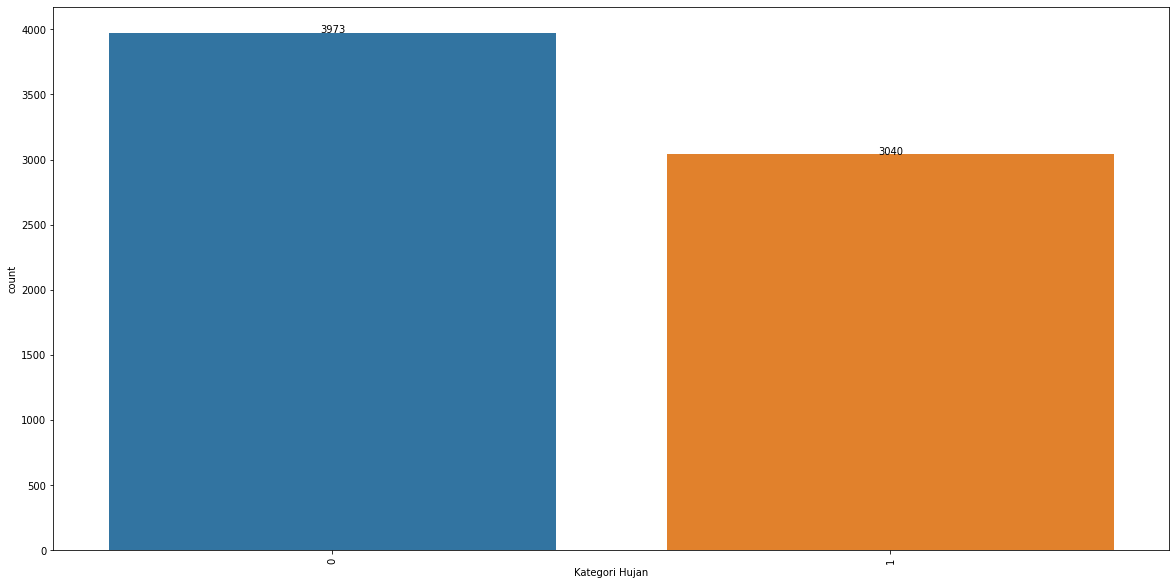

In [ ]:
nKelas = raint.shape[1]
output = 1
reframedTrain = deret_waktu(scaledTrain, lag, output)
#reframedTrain.head()
reframedTest = deret_waktu(scaledTest, lag, output)
#reframedTest.head()
YTrain = reframedTrain.iloc[:, -len(dfTrain.columns):].iloc[:, -(nKelas):].values
YTest = reframedTest.iloc[:, -len(dfTest.columns):].iloc[:, -(nKelas):].values
n_features = len(dfTrain.columns)
n_obs = lag * n_features

train_X, train_y = reframedTrain.iloc[:, :n_obs].values, YTrain
test_X, test_y = reframedTest.iloc[:, :n_obs].values, YTest

#print('data train sebanyak', len(train_X))
#print('data validation sebanyak', len(test_X))
#print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], lag, n_features))
test_X = test_X.reshape((test_X.shape[0], lag, n_features))
#print(train_X.shape)
#print(test_X.shape)
reframed_target = np.argmax(YTrain, axis=1)

rain = pd.DataFrame({'Kategori Hujan':reframed_target})
fig, ax1 = plt.subplots(figsize=(20,10))
graph = sns.countplot(ax=ax1,x='Kategori Hujan', data=rain[['Kategori Hujan']])
graph.set_xticklabels(graph.get_xticklabels(),rotation=90)
i=0
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,
        rain['Kategori Hujan'].value_counts()[i],ha="center")
    i += 1

from sklearn.utils import class_weight

target = np.ravel(reframed_target)

class_weights = class_weight.compute_class_weight(class_weight = 'balanced', 
                                                  classes = np.unique(target), 
                                                  y = target)
class_weights = dict(enumerate(class_weights))
class_weights

In [ ]:
from sklearn.utils import class_weight

target = np.ravel(reframed_target)
class_weights = class_weight.compute_class_weight(class_weight = 'balanced', 
                                                  classes = np.unique(target), 
                                                  y = target)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.8825824314120312, 1: 1.153453947368421}

In [ ]:
from tensorflow.keras.layers import GRU, LSTM, Dense, Bidirectional
from tensorflow.keras.models import Sequential
from keras.layers import Dropout, BatchNormalization
from keras.regularizers import l2, l1_l2
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# design network
model = Sequential()
model.add(GRU(128, return_sequences=False, 
              input_shape=(train_X.shape[-2:])))
model.add(Dense(64, activation="relu"))
model.add(Dense(len(class_weights), activation='softmax'))
model.compile(optimizer=keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=METRICS)  

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 128)               58368     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 66,754
Trainable params: 66,754
Non-trainable params: 0
_________________________________________________________________


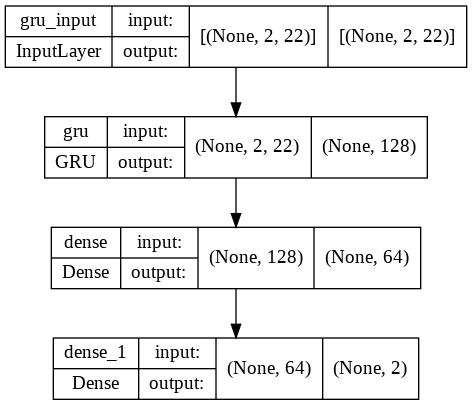

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Epoch 1/10000

Epoch 1: val_loss improved from inf to 0.33675, saving model to model_checkpoint.h5
439/439 - 12s - loss: 0.4209 - tp: 5748.0000 - fp: 1265.0000 - tn: 5748.0000 - fn: 1265.0000 - accuracy: 0.8196 - precision: 0.8196 - recall: 0.8196 - auc: 0.8849 - val_loss: 0.3368 - val_tp: 675.0000 - val_fp: 103.0000 - val_tn: 675.0000 - val_fn: 103.0000 - val_accuracy: 0.8676 - val_precision: 0.8676 - val_recall: 0.8676 - val_auc: 0.9308 - lr: 0.0010 - 12s/epoch - 27ms/step
Epoch 2/10000

Epoch 2: val_loss improved from 0.33675 to 0.33049, saving model to model_checkpoint.h5
439/439 - 3s - loss: 0.3728 - tp: 5948.0000 - fp: 1065.0000 - tn: 5948.0000 - fn: 1065.0000 - accuracy: 0.8481 - precision: 0.8481 - recall: 0.8481 - auc: 0.9094 - val_loss: 0.3305 - val_tp: 674.0000 - val_fp: 104.0000 - val_tn: 674.0000 - val_fn: 104.0000 - val_accuracy: 0.8663 - val_precision: 0.8663 - val_recall: 0.8663 - val_auc: 0.9329 - lr: 0.0010 - 3s/epoch - 6ms/step
Epoch 3/10000

Epoch 3: val_loss improv

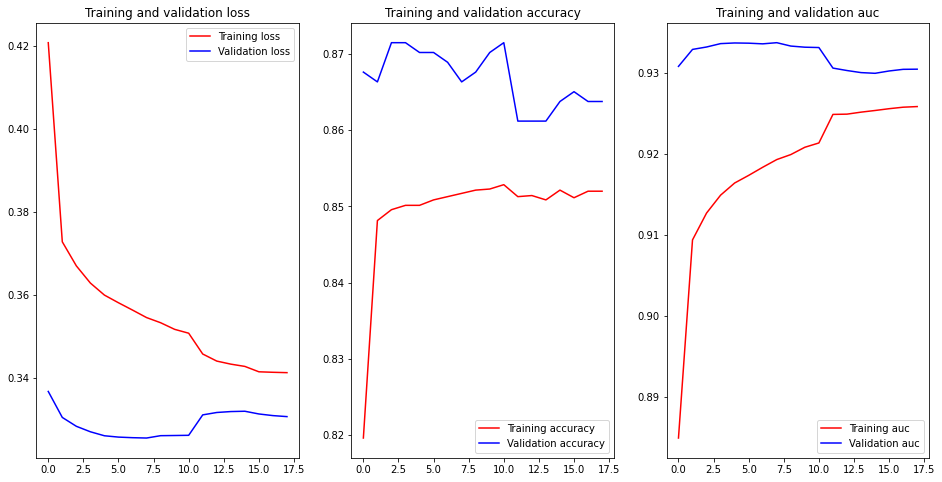

In [ ]:
# fit network
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", 
                                            min_delta=0, patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1)
modelckpt_callback = keras.callbacks.ModelCheckpoint(monitor="val_loss",
                                                     filepath=path_checkpoint, 
                                                     verbose=1, 
                                                     save_weights_only=False, 
                                                     save_best_only=True)
history = model.fit(train_X, train_y, epochs=10000, batch_size=16, 
                    validation_data=(test_X, test_y), verbose=2, shuffle=False, 
                    callbacks=[es_callback, modelckpt_callback, reduce_lr],
                    #)
                    class_weight=class_weights)

# plot history
loss = history.history['loss']
epochs = range(len(loss))

plt.figure(figsize=(16, 8))
plt.subplot(1, 3, 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=1)

plt.subplot(1, 3, 2)
plt.plot(epochs, history.history['accuracy'], 'r', label='Training accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=4)

plt.subplot(1, 3, 3)
plt.plot(epochs, history.history['auc'], 'r', label='Training auc')
plt.plot(epochs, history.history['val_auc'], 'b', label='Validation auc')
plt.title('Training and validation auc')
plt.legend(loc=4)
plt.show()

#out.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

In [ ]:
print("{:.4f}".format(model.evaluate(train_X, train_y, batch_size=256,)))

28/28 [==============================] - 0s 3ms/step - loss: 0.3501
0.3501


In [ ]:
print("{:.4f}".format(model.evaluate(test_X, test_y, batch_size=256,)))

4/4 [==============================] - 0s 3ms/step - loss: 0.3255
0.3255


In [ ]:
start = time.clock()
predictionssT = model.predict(train_X)
elapsed = (time.clock() - start)
print('elapsed', elapsed)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


elapsed 0.7381019999999978


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
preds = np.argmax(predictionssT, axis = 1)
asli = np.argmax(train_y, axis = 1)

from sklearn.metrics import classification_report
print(classification_report(asli, preds, ))

              precision    recall  f1-score   support

           0       0.90      0.83      0.86      3973
           1       0.80      0.88      0.84      3040

    accuracy                           0.85      7013
   macro avg       0.85      0.85      0.85      7013
weighted avg       0.85      0.85      0.85      7013



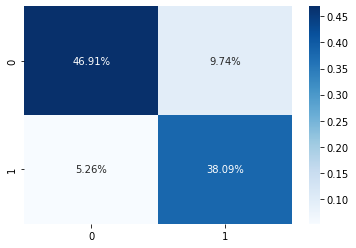

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(asli, preds)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [ ]:
start = time.clock()
predictionss = model.predict(test_X)
elapsed = (time.clock() - start)
print('elapsed', elapsed)

elapsed 0.08750600000000475


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
preds = np.argmax(predictionss, axis = 1)

asli = np.argmax(test_y, axis = 1)

from sklearn.metrics import classification_report
target_names = np.array(['Berawan', 'Hujan Ringan', 'Hujan Sedang', 'Hujan Lebat'])
print(classification_report(asli, preds, ))

              precision    recall  f1-score   support

           0       0.91      0.85      0.88       455
           1       0.81      0.89      0.85       323

    accuracy                           0.87       778
   macro avg       0.86      0.87      0.86       778
weighted avg       0.87      0.87      0.87       778



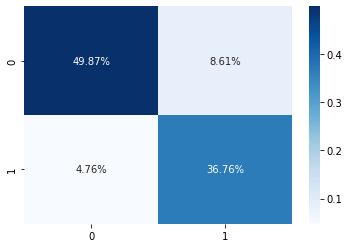

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(asli, preds)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [ ]:
from IPython.core.display import HTML
result = pd.DataFrame({'Prediksi': target_names[preds], 'Asli': target_names[asli]}, columns=['Prediksi', 'Asli'])
display(HTML(result.to_html()))

#Regresi GRU Multistep Sensor2

In [ ]:
# Correlation amongst numeric attributes
corrmat = df.iloc[:, :-14].corr()
cmap = sns.diverging_palette(260,-10,s=50, l=75, n=6, as_cmap=True)
plt.subplots(figsize=(14,14))
sns.heatmap(corrmat,cmap= cmap,annot=True, square=True)

'\n# Correlation amongst numeric attributes\ncorrmat = df.iloc[:, :-14].corr()\ncmap = sns.diverging_palette(260,-10,s=50, l=75, n=6, as_cmap=True)\nplt.subplots(figsize=(14,14))\nsns.heatmap(corrmat,cmap= cmap,annot=True, square=True)\n'

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt
tf.random.set_seed(215)
np.random.seed(215)

####Sensor

In [ ]:
data = df
data.columns

Index(['RH', 'WDSP', 'TEMP', 'SLP', 'MXSPD', 'MIN', 'MAX', 'DEWP', 'MONTH_1',
       'MONTH_2', 'MONTH_3', 'MONTH_4', 'MONTH_5', 'MONTH_6', 'MONTH_7',
       'MONTH_8', 'MONTH_9', 'MONTH_10', 'MONTH_11', 'MONTH_12', 'RAINT_0',
       'RAINT_1'],
      dtype='object')

In [ ]:
hist_window = 2
horizon = 5
#validate = data.tail(horizon)
#data.drop(data.tail(horizon).index,inplace=True)

In [ ]:
def deret_waktu_regresi(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon

    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])

        #indicey = range(i+1, i+1+horizon)
        indicey = range(i, i+horizon)
        y.append(target[indicey])
        
    return np.array(X), np.array(y)

In [ ]:
x_scaler = preprocessing.MinMaxScaler()
y_scaler = preprocessing.MinMaxScaler()
dataX = x_scaler.fit_transform(data)

variabel = ['RH', 'WDSP', 'TEMP', 'SLP', 'MXSPD', 'MIN', 'MAX', 'DEWP']
target = []
for i in range(horizon):
  target += variabel
dataY = y_scaler.fit_transform(data[target])

In [ ]:
"""shutil.copy('rgsXScaler.sav', '/content/drive/Shareddrives/hendri21599/MODELTA/rgsXScaler.sav')
shutil.copy('rgsYScaler.sav', '/content/drive/Shareddrives/hendri21599/MODELTA/rgsYScaler.sav')"""

"shutil.copy('rgsXScaler.sav', '/content/drive/Shareddrives/hendri21599/MODELTA/rgsXScaler.sav')\nshutil.copy('rgsYScaler.sav', '/content/drive/Shareddrives/hendri21599/MODELTA/rgsYScaler.sav')"

In [ ]:
import pickle

pickle.dump(x_scaler, open("x_scaler.sav", "wb"))
pickle.dump(y_scaler, open("y_scaler.sav", "wb"))

In [ ]:
n = int(dataY.shape[1]/horizon)
TRAIN_SPLIT = int(len(data)*.8)
x_train_multi, y_train_multi = deret_waktu_regresi(
    dataX, dataY[:, :n], 0, TRAIN_SPLIT, hist_window, horizon)
x_test_multi, y_test_multi = deret_waktu_regresi(
    dataX, dataY[:, :n], TRAIN_SPLIT, None, hist_window, horizon)

In [ ]:
output = y_train_multi.shape[2]*y_train_multi.shape[1]
y_train_multi = y_train_multi.reshape(-1, output, 1)
y_test_multi = y_test_multi.reshape(-1, output, 1)
print ('Single window of past history')
print(x_train_multi[0])
print ('\n Target horizon')
print (y_train_multi[0])

Single window of past history
[[0.58021807 0.27560785 0.32525509 0.33031528 0.32736551 0.52382353
  0.53780573 0.7285568  1.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         1.        ]
 [0.544943   0.33432796 0.34732766 0.37348149 0.38731115 0.55684679
  0.50990649 0.70261756 1.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         1.        ]]

 Target horizon
[[0.55762185]
 [0.32857897]
 [0.29402185]
 [0.43709722]
 [0.29936016]
 [0.53867322]
 [0.32485313]
 [0.67757828]
 [0.53496934]
 [0.24152354]
 [0.38884277]
 [0.42408031]
 [0.11404289]
 [0.57781901]
 [0.30369566]
 [0.72186631]
 [0.49464064]
 [0.16813322]
 [0.53955108]
 [0.36273979]
 [0.15873633]
 [0.65368332]
 [0.5147879 ]
 [0.78551804]
 [0.53288071]
 [0.1716041 ]
 [0.46558462]
 [0.34882504]
 [0.4082498 ]
 [0.62395553]
 [0.62182662]
 [0.77748747]
 [0.62904564]
 [0.20592732]
 [0.24

In [ ]:
BATCH_SIZE = 128
BUFFER_SIZE = 150

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_test_multi, y_test_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [ ]:
x_train_multi.shape[-2:]

(2, 22)

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import GRU, LSTM, Dense, Bidirectional
from tensorflow.keras.models import Sequential
from keras.layers import Dropout, BatchNormalization
from keras.regularizers import l2, l1_l2
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

model = Sequential()
model.add(Bidirectional(GRU(32, return_sequences=False), 
                        input_shape=x_train_multi.shape[-2:]))
model.add(Dense(512, activation='relu')),
model.add(Dense(output, activation='relu'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='mse')

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 64)               10752     
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 512)               33280     
                                                                 
 dense_13 (Dense)            (None, 40)                20520     
                                                                 
Total params: 64,552
Trainable params: 64,552
Non-trainable params: 0
_________________________________________________________________


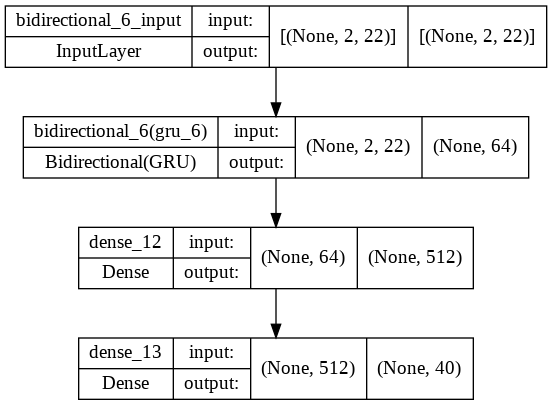

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
EVALUATION_INTERVAL = 100
EPOCHS = 10000
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", 
                                            min_delta=0, patience=10, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
modelckpt_callback = keras.callbacks.ModelCheckpoint(monitor="val_loss",
                                                     filepath='fitur_checkpoint.h5', 
                                                     verbose=1, 
                                                     mode='min',
                                                     save_weights_only=False, 
                                                     save_best_only=True)
history = model.fit(train_data_multi, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, validation_data=val_data_multi, validation_steps=50, verbose=1,
                                   callbacks=[es_callback, reduce_lr, modelckpt_callback])

Epoch 1/10000
 97/100 [============================>.] - ETA: 0s - loss: 0.1196
Epoch 1: val_loss improved from inf to 0.03808, saving model to fitur_checkpoint.h5
100/100 [==============================] - 5s 13ms/step - loss: 0.1174 - val_loss: 0.0381 - lr: 1.0000e-04
Epoch 2/10000
 92/100 [==========================>...] - ETA: 0s - loss: 0.0364
Epoch 2: val_loss improved from 0.03808 to 0.03301, saving model to fitur_checkpoint.h5
100/100 [==============================] - 1s 6ms/step - loss: 0.0363 - val_loss: 0.0330 - lr: 1.0000e-04
Epoch 3/10000
 90/100 [==========================>...] - ETA: 0s - loss: 0.0334
Epoch 3: val_loss improved from 0.03301 to 0.03108, saving model to fitur_checkpoint.h5
100/100 [==============================] - 1s 6ms/step - loss: 0.0334 - val_loss: 0.0311 - lr: 1.0000e-04
Epoch 4/10000
100/100 [==============================] - ETA: 0s - loss: 0.0317
Epoch 4: val_loss improved from 0.03108 to 0.02986, saving model to fitur_checkpoint.h5
100/100 [====

No handles with labels found to put in legend.


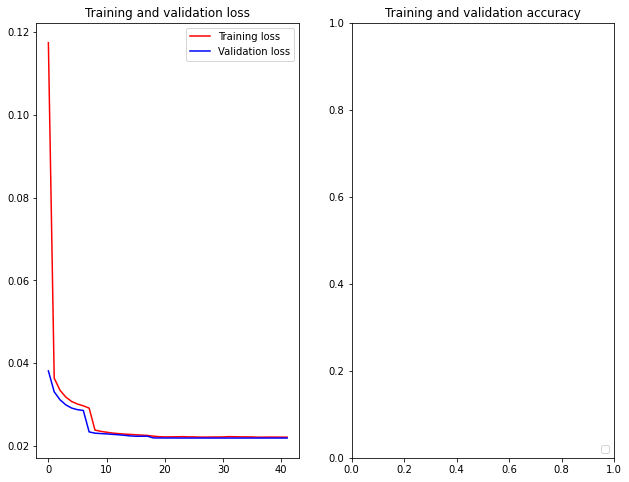

In [ ]:
# plot history
loss = history.history['loss']
epochs = range(len(loss))

plt.figure(figsize=(16, 8))
plt.subplot(1, 3, 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=1)

plt.subplot(1, 3, 2)
#plt.plot(epochs, history.history['accuracy'], 'r', label='Training accuracy')
#plt.plot(epochs, history.history['val_accuracy'], 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=4)

#out.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

In [ ]:
model.load_weights('/content/fitur_checkpoint.h5')
model.compile(optimizer=keras.optimizers.Adam(), loss='mse')

# Show the model architecture
#import shutil
#shutil.copy('/content/fitur_checkpoint.h5', '/content/drive/Shareddrives/hendri21599/MODELTA/'+'5rgs'+str(hist_window)+'day'+'.h5')

In [ ]:
"""model.load_weights('/content/drive/Shareddrives/hendri21599/MODELTA/'+'5rgs'+str(hist_window)+'day'+'.h5')
model.compile(optimizer=keras.optimizers.Adam(), loss='mse')"""

"model.load_weights('/content/drive/Shareddrives/hendri21599/MODELTA/'+'5rgs'+str(hist_window)+'day'+'.h5')\nmodel.compile(optimizer=keras.optimizers.Adam(), loss='mse')"

In [ ]:
model.evaluate(x_train_multi, y_train_multi)

195/195 [==============================] - 1s 3ms/step - loss: 0.0221


0.022095846012234688

In [ ]:
model.evaluate(x_test_multi, y_test_multi)

49/49 [==============================] - 0s 2ms/step - loss: 0.0218


0.02184181846678257

In [ ]:
start = time.clock()
predictionssT = model.predict(x_train_multi)
elapsed = (time.clock() - start)
print('elapsed', elapsed)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


elapsed 1.0110189999999761


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
start = time.clock()
predictionss = model.predict(x_test_multi)
elapsed = (time.clock() - start)
print('elapsed', elapsed)

elapsed 0.14555000000001428


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
"""data_val = x_scaler.transform(data.tail(hist_window))
val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])
Predicted_results = Trained_model.predict(val_rescaled)
print(Predicted_results)
Predicted_results_Inv_trans = y_scaler.inverse_transform(Predicted_results)
print(Predicted_results_Inv_trans)
#timeseries_evaluation_metrics_func(validate[target], Predicted_results_Inv_trans.reshape(-1, n))
plt.plot( list(validate['RH']))
plt.plot( list(Predicted_results_Inv_trans[0]))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show()"""


pred = model.predict(x_test_multi).reshape(-1, dataY.shape[1])
#pred = model.predict(x_train_multi).reshape(-1, dataY.shape[1])
preds = y_scaler.inverse_transform(pred)
pd.DataFrame(preds, columns=target).head()

asli = y_test_multi.reshape(-1, dataY.shape[1])
#asli = y_train_multi.reshape(-1, dataY.shape[1])
aslis = y_scaler.inverse_transform(asli)
#pd.DataFrame(aslis, columns=target).head()

In [ ]:
"""arr_rh = [i for i in range(0,len(target),len(variabel))]
arr_wdsp = [i for i in range(1,len(target),len(variabel))]
arr_temp = [i for i in range(2,len(target),len(variabel))]
arr_slp = [i for i in range(3,len(target),len(variabel))]
arr_mxspd = [i for i in range(4,len(target),len(variabel))]
arr_min = [i for i in range(5,len(target),len(variabel))]
arr_max = [i for i in range(6,len(target),len(variabel))]
arr_dewp = [i for i in range(7,len(target),len(variabel))]
for var in arr_wdsp:
  timeseries_evaluation_metrics_func(aslis[:,var], preds[:,var])
  """

from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
    return round(np.sqrt(metrics.mean_squared_error(y_true, y_pred)), 2)

arr_rh = []
arr_wdsp = []
arr_temp = []
arr_slp = []
arr_mxspd = []
arr_min = []
arr_max = []
arr_dewp = []

for var in [i for i in range(0,len(target),len(variabel))]:
  arr_rh.append(timeseries_evaluation_metrics_func(aslis[:,var], preds[:,var]))
  arr_wdsp.append(timeseries_evaluation_metrics_func(aslis[:,var+1], preds[:,var+1]))
  arr_temp.append(timeseries_evaluation_metrics_func(aslis[:,var+2], preds[:,var+2]))
  arr_slp.append(timeseries_evaluation_metrics_func(aslis[:,var+3], preds[:,var+3]))
  arr_mxspd.append(timeseries_evaluation_metrics_func(aslis[:,var+4], preds[:,var+4]))
  arr_min.append(timeseries_evaluation_metrics_func(aslis[:,var+5], preds[:,var+5]))
  arr_max.append(timeseries_evaluation_metrics_func(aslis[:,var+6], preds[:,var+6]))
  arr_dewp.append(timeseries_evaluation_metrics_func(aslis[:,var+7], preds[:,var+7]))

pd.set_option("display.precision", 2)
pd.DataFrame([arr_rh, arr_wdsp, arr_temp, arr_slp, arr_mxspd, arr_min, arr_max, arr_dewp]).T.style.hide_index()

0,1,2,3,4,5,6,7
2.95,1.09,0.53,0.70,1.80,0.57,0.58,0.57
3.78,1.31,0.68,0.88,2.12,0.72,0.72,0.73
4.15,1.38,0.74,0.98,2.21,5.46,0.76,0.82
4.29,1.40,0.75,1.03,2.21,0.83,0.79,0.86
4.36,1.40,0.75,1.06,6.17,0.84,0.79,0.86


In [ ]:
#pd.DataFrame(preds).to_csv('pred.csv')
#pd.DataFrame(aslis).to_csv('asli.csv')

In [ ]:
plt.plot( aslis[:,0])
plt.plot( preds[:,0])
plt.title("Actual vs Predicted")
plt.ylabel("Relative Humidity")
plt.legend(('Actual','predicted'))
plt.show()

#PREDICT RAIN 5 Hari kedepan

In [ ]:
csv_path = "agustus.csv"
df = pd.read_csv(csv_path, parse_dates=['DATE'], index_col='DATE')
df.drop(['NAME', 'LATITUDE', 'LONGITUDE', 'STP', 'VISIB'], axis=1, inplace=True)
# Konversi F ke C
def FtoC(valF):
     return (valF - 32) * 5/9 
    
def InchToMm(valInch):
    return valInch*25.4

perluKonversi = ['DEWP', 'MIN', 'MAX', 'TEMP', 'PRCP']
for i in perluKonversi:
    if i == 'PRCP':
        df[i] = df.apply(lambda row : InchToMm(row[i]), axis = 1)    
    else:
        df[i] = df.apply(lambda row : FtoC(row[i]), axis = 1)

df.head()

,PRCP,DEWP,MAX,MIN,MXSPD,SLP,TEMP,WDSP
DATE,,,,,,,,
2021-08-01,0.0,22.28,32.78,24.00,13.0,1010.7,28.11,4.6
2021-08-02,0.0,22.61,32.39,23.61,12.0,1011.3,28.22,4.6
2021-08-03,0.0,23.67,33.22,24.61,9.9,1012.3,28.17,6.1
2021-08-04,0.0,23.33,32.22,24.28,11.1,1012.5,28.39,6.1
2021-08-05,0.0,22.61,32.00,24.39,9.9,1013.0,28.44,5.9


In [ ]:
#Penurunan fitur
def getRH(valT, valDp):
    T = valT + 273.15
    Td = valDp + 273.15
    L = 2.501*10**6
    Rw = 461.5
    RH = np.exp((-T/Td+1) * L / (T*Rw))
    return RH*100
df['RH'] = df.apply(lambda row : getRH(row['TEMP'], row['DEWP']), axis = 1)

#ekstrak bulan
df['MONTH'] = df.index.month

#rain category
def RainCat(valMm):
    if valMm >= 0.5:
        return 1 
    elif valMm < 0.5:
        return 0 
df['RAINTODAY'] = df.apply(lambda row : RainCat(row['PRCP']), axis = 1)
df = df[df.columns[::-1]]
df.dropna(inplace=True)

for i in range(1, 13):
  df['MONTH_'+str(i)] = 0
df['MONTH'] = df.index.month
month = pd.get_dummies(df['MONTH'], prefix='MONTH')
for month_ in month.columns:
  df[month_] = month[month_]

for i in range(0, 2):
  df['RAINT_'+str(i)] = 0
raint = pd.get_dummies(df['RAINTODAY'], prefix='RAINT')
for raint_ in raint.columns:
  df[raint_] = raint[raint_]

df.drop(['RAINTODAY', 'MONTH', 'PRCP'], axis=1, inplace=True)

df.head()

,RH,WDSP,TEMP,SLP,MXSPD,MIN,MAX,DEWP,MONTH_1,MONTH_2,...,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,RAINT_0,RAINT_1
DATE,,,,,,,,,,,,,,,,,,,,,
2021-08-01,70.10,4.6,28.11,1010.7,13.0,24.00,32.78,22.28,0,0,...,0,0,0,1,0,0,0,0,1,0
2021-08-02,71.10,4.6,28.22,1011.3,12.0,23.61,32.39,22.61,0,0,...,0,0,0,1,0,0,0,0,1,0
2021-08-03,76.13,6.1,28.17,1012.3,9.9,24.61,33.22,23.67,0,0,...,0,0,0,1,0,0,0,0,1,0
2021-08-04,73.61,6.1,28.39,1012.5,11.1,24.28,32.22,23.33,0,0,...,0,0,0,1,0,0,0,0,1,0
2021-08-05,70.16,5.9,28.44,1013.0,9.9,24.39,32.00,22.61,0,0,...,0,0,0,1,0,0,0,0,1,0


In [ ]:
start = 0
end = 21
input = df.iloc[start:end+start, :]
input

,RH,WDSP,TEMP,SLP,MXSPD,MIN,MAX,DEWP,MONTH_1,MONTH_2,...,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,RAINT_0,RAINT_1
DATE,,,,,,,,,,,,,,,,,,,,,
2021-08-01,70.10,4.6,28.11,1010.7,13.0,24.00,32.78,22.28,0,0,...,0,0,0,1,0,0,0,0,1,0
2021-08-02,71.10,4.6,28.22,1011.3,12.0,23.61,32.39,22.61,0,0,...,0,0,0,1,0,0,0,0,1,0
2021-08-03,76.13,6.1,28.17,1012.3,9.9,24.61,33.22,23.67,0,0,...,0,0,0,1,0,0,0,0,1,0
2021-08-04,73.61,6.1,28.39,1012.5,11.1,24.28,32.22,23.33,0,0,...,0,0,0,1,0,0,0,0,1,0
2021-08-05,70.16,5.9,28.44,1013.0,9.9,24.39,32.00,22.61,0,0,...,0,0,0,1,0,0,0,0,1,0
2021-08-06,71.40,8.5,28.61,1012.2,14.0,24.78,32.39,23.06,0,0,...,0,0,0,1,0,0,0,0,1,0
2021-08-07,72.74,9.6,29.28,1012.4,15.9,26.50,32.11,24.00,0,0,...,0,0,0,1,0,0,0,0,1,0
2021-08-08,73.72,8.5,29.17,1011.9,15.0,26.22,32.22,24.11,0,0,...,0,0,0,1,0,0,0,0,1,0
2021-08-09,75.69,8.5,28.67,1010.9,13.0,25.28,32.00,24.06,0,0,...,0,0,0,1,0,0,0,0,1,0


In [ ]:
hist_window = 14 

In [ ]:
modelR = tf.keras.models.load_model('/content/fitur_checkpoint.h5')

###Data Prediksi

In [ ]:
len(df.columns)

22

In [ ]:
input

,RH,WDSP,TEMP,SLP,MXSPD,MIN,MAX,DEWP,MONTH_1,MONTH_2,...,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,RAINT_0,RAINT_1
DATE,,,,,,,,,,,,,,,,,,,,,
2021-08-01,70.10,4.6,28.11,1010.7,13.0,24.00,32.78,22.28,0,0,...,0,0,0,1,0,0,0,0,1,0
2021-08-02,71.10,4.6,28.22,1011.3,12.0,23.61,32.39,22.61,0,0,...,0,0,0,1,0,0,0,0,1,0
2021-08-03,76.13,6.1,28.17,1012.3,9.9,24.61,33.22,23.67,0,0,...,0,0,0,1,0,0,0,0,1,0
2021-08-04,73.61,6.1,28.39,1012.5,11.1,24.28,32.22,23.33,0,0,...,0,0,0,1,0,0,0,0,1,0
2021-08-05,70.16,5.9,28.44,1013.0,9.9,24.39,32.00,22.61,0,0,...,0,0,0,1,0,0,0,0,1,0
2021-08-06,71.40,8.5,28.61,1012.2,14.0,24.78,32.39,23.06,0,0,...,0,0,0,1,0,0,0,0,1,0
2021-08-07,72.74,9.6,29.28,1012.4,15.9,26.50,32.11,24.00,0,0,...,0,0,0,1,0,0,0,0,1,0
2021-08-08,73.72,8.5,29.17,1011.9,15.0,26.22,32.22,24.11,0,0,...,0,0,0,1,0,0,0,0,1,0
2021-08-09,75.69,8.5,28.67,1010.9,13.0,25.28,32.00,24.06,0,0,...,0,0,0,1,0,0,0,0,1,0


In [ ]:
from datetime import date, timedelta, datetime
import pickle

#x_scaler = pickle.load(open('/content/drive/Shareddrives/hendri21599/MODELTA/rgsXScaler.sav', 'rb'))
#y_scaler = pickle.load(open('/content/drive/Shareddrives/hendri21599/MODELTA/rgsYScaler.sav', 'rb'))
x_multi = x_scaler.transform(input)
x_multi = x_multi.reshape(-1, 21, 22)
x_multi.shape
variabel = ['RH', 'WDSP', 'TEMP', 'SLP', 'MXSPD', 'MIN', 'MAX', 'DEWP']

preds = modelR.predict(x_multi)
preds = y_scaler.inverse_transform(preds)
predsensor = pd.DataFrame(preds.reshape(-1, len(variabel)), columns=variabel)
inputt = pd.concat([input.iloc[-7:, :8], predsensor],ignore_index=True)

#yesterday = '2021-06-26'
today = datetime.strptime('2021-08-21', '%Y-%m-%d')
#yesterday = date.today() - timedelta(days=1)
yesterday = today - timedelta(days=6)
index = pd.date_range(yesterday, periods=len(inputt), freq='D')
inputt.set_index(index, inplace=True)
inputt # hasil kemarin6, hari ini, 5 hari kedepan

,RH,WDSP,TEMP,SLP,MXSPD,MIN,MAX,DEWP
2021-08-19,71.66,8.90,28.67,1011.50,13.00,24.28,31.78,23.17
2021-08-20,68.97,5.30,28.50,1012.50,8.90,24.39,32.00,22.39
2021-08-21,69.76,4.20,28.94,1010.80,11.10,24.22,33.22,23.00
2021-08-22,71.86,3.40,28.39,1009.50,6.00,24.72,32.22,22.94
2021-08-23,69.89,5.90,28.28,1010.10,9.90,24.39,32.78,22.39
2021-08-24,69.14,5.40,28.11,1010.90,12.00,24.22,32.22,22.06
2021-08-25,71.13,4.70,28.44,1011.00,9.90,24.39,33.00,22.83
2021-08-26,70.30,6.24,28.51,1004.00,11.82,19.00,32.29,22.61
2021-08-27,69.02,6.25,28.53,1010.63,11.22,23.95,32.41,22.57
2021-08-28,69.54,6.18,28.52,1010.73,11.67,24.05,32.38,22.49


In [ ]:
for i in range(1, 13):
  inputt['MONTH_'+str(i)] = 0
  
inputt['MONTH'] = inputt.index.month
month = pd.get_dummies(inputt['MONTH'], prefix='MONTH')
for month_ in month.columns:
  inputt[month_] = month[month_]
inputt.drop(['MONTH'], axis=1, inplace=True)
inputt = inputt.join(input.iloc[-7:, -2:])
inputt

,RH,WDSP,TEMP,SLP,MXSPD,MIN,MAX,DEWP,MONTH_1,MONTH_2,...,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,RAINT_0,RAINT_1
2021-08-19,71.66,8.90,28.67,1011.50,13.00,24.28,31.78,23.17,0,0,...,0,0,0,1,0,0,0,0,NaN,NaN
2021-08-20,68.97,5.30,28.50,1012.50,8.90,24.39,32.00,22.39,0,0,...,0,0,0,1,0,0,0,0,1.0,0.0
2021-08-21,69.76,4.20,28.94,1010.80,11.10,24.22,33.22,23.00,0,0,...,0,0,0,1,0,0,0,0,1.0,0.0
2021-08-22,71.86,3.40,28.39,1009.50,6.00,24.72,32.22,22.94,0,0,...,0,0,0,1,0,0,0,0,NaN,NaN
2021-08-23,69.89,5.90,28.28,1010.10,9.90,24.39,32.78,22.39,0,0,...,0,0,0,1,0,0,0,0,NaN,NaN
2021-08-24,69.14,5.40,28.11,1010.90,12.00,24.22,32.22,22.06,0,0,...,0,0,0,1,0,0,0,0,NaN,NaN
2021-08-25,71.13,4.70,28.44,1011.00,9.90,24.39,33.00,22.83,0,0,...,0,0,0,1,0,0,0,0,NaN,NaN
2021-08-26,70.30,6.24,28.51,1004.00,11.82,19.00,32.29,22.61,0,0,...,0,0,0,1,0,0,0,0,NaN,NaN
2021-08-27,69.02,6.25,28.53,1010.63,11.22,23.95,32.41,22.57,0,0,...,0,0,0,1,0,0,0,0,NaN,NaN
2021-08-28,69.54,6.18,28.52,1010.73,11.67,24.05,32.38,22.49,0,0,...,0,0,0,1,0,0,0,0,NaN,NaN


In [ ]:
def deret_waktu(data, n_in=1, n_out=1, dropnan=True,):
    n_vars = (1 if type(data) is list else data.shape[1])
    df = DataFrame(data)
    (cols, names) = (list(), list())
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += ['var%d(t-%d)' % (j + 1, i) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += ['var%d(t)' % (j + 1) for j in range(n_vars)]
        else:
            names += ['var%d(t+%d)' % (j + 1, i) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
model = tf.keras.models.load_model('/content/model_checkpoint.h5')

In [ ]:
inputt

,RH,WDSP,TEMP,SLP,MXSPD,MIN,MAX,DEWP,MONTH_1,MONTH_2,...,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,RAINT_0,RAINT_1
2021-08-15,71.66,8.90,28.67,1011.50,13.00,24.28,31.78,23.17,0,0,...,0,0,0,1,0,0,0,0,1.0,0.0
2021-08-16,68.97,5.30,28.50,1012.50,8.90,24.39,32.00,22.39,0,0,...,0,0,0,1,0,0,0,0,1.0,0.0
2021-08-17,69.76,4.20,28.94,1010.80,11.10,24.22,33.22,23.00,0,0,...,0,0,0,1,0,0,0,0,1.0,0.0
2021-08-18,71.86,3.40,28.39,1009.50,6.00,24.72,32.22,22.94,0,0,...,0,0,0,1,0,0,0,0,1.0,0.0
2021-08-19,69.89,5.90,28.28,1010.10,9.90,24.39,32.78,22.39,0,0,...,0,0,0,1,0,0,0,0,1.0,0.0
2021-08-20,69.14,5.40,28.11,1010.90,12.00,24.22,32.22,22.06,0,0,...,0,0,0,1,0,0,0,0,1.0,0.0
2021-08-21,71.13,4.70,28.44,1011.00,9.90,24.39,33.00,22.83,0,0,...,0,0,0,1,0,0,0,0,1.0,0.0
2021-08-22,70.30,6.24,28.51,1004.00,11.82,19.00,32.29,22.61,0,0,...,0,0,0,1,0,0,0,0,NaN,NaN
2021-08-23,69.02,6.25,28.53,1010.63,11.22,23.95,32.41,22.57,0,0,...,0,0,0,1,0,0,0,0,NaN,NaN
2021-08-24,69.54,6.18,28.52,1010.73,11.67,24.05,32.38,22.49,0,0,...,0,0,0,1,0,0,0,0,NaN,NaN


In [ ]:
import pickle

for i in range(0, 5):
  scaledFitur = scaler.transform(inputt[i:]) #looping 0++
  input_clf = deret_waktu(scaledFitur, 7, 0).values
  input_clf = input_clf.reshape((input_clf.shape[0], 7, 22))
  next = model.predict(input_clf)
  inputt.iloc[7+i, -2:] = np.ravel(next) #looping 7++

inputt

In [ ]:
scaledFitur = scaler.transform(inputt[1:])
input_clf = deret_waktu(scaledFitur, 2, 0).values
input_clf.shape

(5, 44)

In [ ]:
pd.concat([inputt.iloc[:, 0:8], inputt.iloc[:, -2:]], axis=1)

,RH,WDSP,TEMP,SLP,MXSPD,MIN,MAX,DEWP,RAINT_0,RAINT_1
2021-11-08,76.524111,4.700000,29.111111,1007.300000,8.900000,25.222222,33.777778,24.666667,1.0,0.0
2021-11-09,76.486154,5.600000,28.833333,1007.600000,8.000000,24.388889,33.777778,24.388889,1.0,0.0
2021-11-10,79.065146,4.600000,28.333333,1007.800000,8.000000,25.500000,33.388889,24.444444,0.0,1.0
2021-11-11,85.622649,4.600000,26.833333,1008.400000,9.900000,24.777778,33.388889,24.277778,0.0,1.0
2021-11-12,76.910736,2.700000,28.111111,1009.000000,8.000000,23.611111,31.000000,23.777778,1.0,0.0
2021-11-13,87.104169,3.900000,27.000000,1008.900000,8.000000,24.777778,31.388889,24.722222,0.0,1.0
2021-11-14,86.472812,4.500000,26.500000,1008.900000,8.000000,24.000000,30.777778,24.111111,0.0,1.0
2021-11-15,82.145706,4.004693,27.405090,1008.632202,9.102132,24.247679,31.735689,24.189383,0.0,1.0
2021-11-16,81.434265,4.243447,27.527100,1008.678711,9.390162,24.349192,31.838942,24.158419,0.0,1.0
2021-11-17,80.886452,4.420294,27.611792,1008.682495,9.642499,24.398933,31.911137,24.122677,0.0,1.0


In [ ]:
pd.concat([df.iloc[start:end+start+5, :].tail(12).iloc[:, 0:8], df.iloc[start:end+start+5, :].tail(12).iloc[:, -2:]], axis=1)

,RH,WDSP,TEMP,SLP,MXSPD,MIN,MAX,DEWP,RAINT_0,RAINT_1
DATE,,,,,,,,,,
2021-11-08,76.524111,4.7,29.111111,1007.3,8.9,25.222222,33.777778,24.666667,1,0
2021-11-09,76.486154,5.6,28.833333,1007.6,8.0,24.388889,33.777778,24.388889,1,0
2021-11-10,79.065146,4.6,28.333333,1007.8,8.0,25.500000,33.388889,24.444444,0,1
2021-11-11,85.622649,4.6,26.833333,1008.4,9.9,24.777778,33.388889,24.277778,0,1
2021-11-12,76.910736,2.7,28.111111,1009.0,8.0,23.611111,31.000000,23.777778,1,0
2021-11-13,87.104169,3.9,27.000000,1008.9,8.0,24.777778,31.388889,24.722222,0,1
2021-11-14,86.472812,4.5,26.500000,1008.9,8.0,24.000000,30.777778,24.111111,0,1
2021-11-15,90.352102,2.5,26.055556,1008.6,6.0,24.611111,29.777778,24.388889,0,1
2021-11-16,88.549222,3.5,26.388889,1009.2,9.9,24.388889,31.388889,24.388889,0,1


#PENGUJIAN BAB 4

In [ ]:
import datetime
import pandas as pd
import pickle
import tensorflow as tf
from datetime import timedelta, datetime
import numpy as np
import matplotlib.pyplot as plt

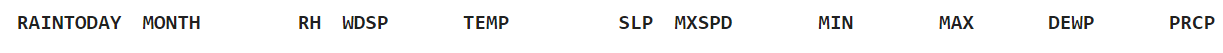

In [ ]:
input = pd.read_csv('sensorHendri14HariMean2std.csv', parse_dates=['date'], index_col='date')
input = pd.DataFrame(input, columns=['PRCP', 'DEWP', 'MAX', 'MIN', 'MXSPD', 'SLP', 'TEMP', 'WDSP', 'RH'])
input

,PRCP,DEWP,MAX,MIN,MXSPD,SLP,TEMP,WDSP,RH
date,,,,,,,,,
2022-05-18,1.3,24.650819,37.375335,22.859151,3,1008.944169,29.620283,5.904196,74.746836
2022-05-19,0.4,24.641542,36.450522,20.799332,1,1008.892789,29.688404,5.963120,74.597947
2022-05-20,1.6,24.637936,37.182022,22.587707,2,1008.890835,29.739120,6.061069,74.862574
2022-05-21,9.9,24.632189,36.879213,22.215729,2,1008.888748,29.668694,6.019462,75.040204
2022-05-22,2.0,24.642418,37.080301,22.943242,4,1008.897467,29.588935,5.928765,74.294064
2022-05-23,6.3,24.645318,38.474226,21.101211,4,1008.872531,29.762138,5.861701,75.089492
2022-05-24,0.0,24.653889,36.229097,21.757718,4,1008.938324,29.764143,5.905150,74.725352
2022-05-25,29.0,24.615436,37.837817,22.270095,2,1008.911679,29.732429,6.018310,75.211182
2022-05-26,0.0,24.602642,37.313654,22.554392,2,1008.878505,29.683104,5.910914,74.949098


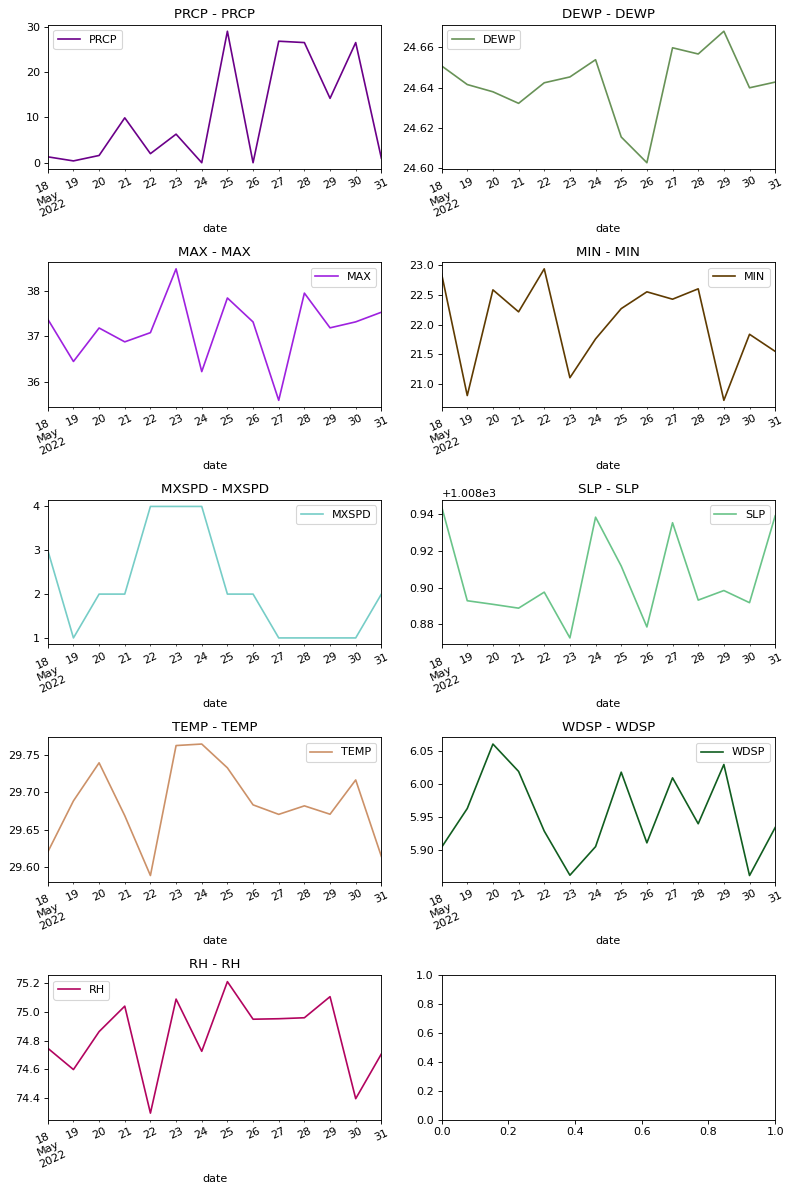

In [ ]:
import random

def show_raw_visualization(data, rows=4):
    titles = list(data)
    feature_keys = list(data)
    #time_data = data[date_time_key]
    time_data = data.index
    fig, axes = plt.subplots(
        nrows=rows, ncols=2, figsize=(10, 15), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = random.random(), random.random(), random.random()
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()
show_raw_visualization(input, rows=5)

In [ ]:
for i in range(1, 13):
    input['MONTH_'+str(i)] = 0
input['MONTH'] = input.index.month
month = pd.get_dummies(input['MONTH'], prefix='MONTH')
for month_ in month.columns:
    input[month_] = month[month_]

def RainCat(valMm):
    if valMm >= 0.5:
        return 1 
    elif valMm < 0.5:
        return 0 

input['RAINTODAY'] = input.apply(lambda row : RainCat(row['PRCP']), axis = 1)

for i in range(0, 2):
    input['RAINT_'+str(i)] = 0
raint = pd.get_dummies(input['RAINTODAY'], prefix='RAINT')
for raint_ in raint.columns:
    input[raint_] = raint[raint_]
input.drop(['MONTH', 'RAINTODAY', 'PRCP'], axis=1, inplace=True)
input

,DEWP,MAX,MIN,MXSPD,SLP,TEMP,WDSP,RH,MONTH_1,MONTH_2,...,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,RAINT_0,RAINT_1
date,,,,,,,,,,,,,,,,,,,,,
2022-05-18,24.650819,37.375335,22.859151,3,1008.944169,29.620283,5.904196,74.746836,0,0,...,1,0,0,0,0,0,0,0,0,1
2022-05-19,24.641542,36.450522,20.799332,1,1008.892789,29.688404,5.963120,74.597947,0,0,...,1,0,0,0,0,0,0,0,1,0
2022-05-20,24.637936,37.182022,22.587707,2,1008.890835,29.739120,6.061069,74.862574,0,0,...,1,0,0,0,0,0,0,0,0,1
2022-05-21,24.632189,36.879213,22.215729,2,1008.888748,29.668694,6.019462,75.040204,0,0,...,1,0,0,0,0,0,0,0,0,1
2022-05-22,24.642418,37.080301,22.943242,4,1008.897467,29.588935,5.928765,74.294064,0,0,...,1,0,0,0,0,0,0,0,0,1
2022-05-23,24.645318,38.474226,21.101211,4,1008.872531,29.762138,5.861701,75.089492,0,0,...,1,0,0,0,0,0,0,0,0,1
2022-05-24,24.653889,36.229097,21.757718,4,1008.938324,29.764143,5.905150,74.725352,0,0,...,1,0,0,0,0,0,0,0,1,0
2022-05-25,24.615436,37.837817,22.270095,2,1008.911679,29.732429,6.018310,75.211182,0,0,...,1,0,0,0,0,0,0,0,0,1
2022-05-26,24.602642,37.313654,22.554392,2,1008.878505,29.683104,5.910914,74.949098,0,0,...,1,0,0,0,0,0,0,0,1,0


In [ ]:
modelR = tf.keras.models.load_model('modelRegresi.h5')
input = input.reindex(['RH', 'WDSP', 'TEMP', 'SLP', 'MXSPD', 'MIN',
'MAX', 'DEWP', 'MONTH_1', 'MONTH_2', 'MONTH_3', 'MONTH_4',
'MONTH_5', 'MONTH_6', 'MONTH_7', 'MONTH_8', 'MONTH_9', 'MONTH_10',
'MONTH_11', 'MONTH_12', 'RAINT_0', 'RAINT_1'], axis=1)
x_scaler = pickle.load(open('x_scaler.sav', 'rb'))
y_scaler = pickle.load(open('y_scaler.sav', 'rb'))
x_multi = x_scaler.transform(input)
x_multi = x_multi.reshape(-1, 14, 22)
variabel = ['RH', 'WDSP', 'TEMP', 'SLP', 'MXSPD', 'MIN', 'MAX', 'DEWP']
preds = modelR.predict(x_multi)
preds = y_scaler.inverse_transform(preds)
predsensor = pd.DataFrame(preds.reshape(-1, len(variabel)), columns=variabel)
predsensor

,RH,WDSP,TEMP,SLP,MXSPD,MIN,MAX,DEWP
0,77.493431,3.854408,29.686653,1009.975647,8.561380,25.243870,33.890076,25.439217
1,77.663002,4.108676,29.647482,1010.192810,8.638636,25.473078,33.599796,24.718660
2,81.058151,3.964311,29.017952,1010.005005,5.100000,25.675591,33.517056,25.109089
3,79.488533,4.173643,29.014971,1010.000122,8.138639,19.000000,33.221466,25.281464
4,83.604599,4.156448,28.612720,1010.427063,8.079434,25.188038,33.141811,24.877426


In [ ]:
def DeretWaktu(data, n_in=1, n_out=1, dropnan=True,):
    n_vars = (1 if type(data) is list else data.shape[1])
    df = pd.DataFrame(data)
    (cols, names) = (list(), list())
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += ['var%d(t-%d)' % (j + 1, i) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += ['var%d(t)' % (j + 1) for j in range(n_vars)]
        else:
            names += ['var%d(t+%d)' % (j + 1, i) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
modelK = tf.keras.models.load_model('modelKlasifikasi.h5')

n_days = 2
today = '2022-05-31'
inputt = pd.concat([input.iloc[-n_days:, :8], predsensor],ignore_index=True)
tdy = datetime.strptime(today, '%Y-%m-%d')
yst = tdy - timedelta(days=n_days-1)
index = pd.date_range(yst, periods=len(inputt), freq='D')
inputt.set_index(index, inplace=True)
for i in range(1, 13):
    inputt['MONTH_'+str(i)] = 0

inputt = inputt.join(input.iloc[-n_days:, -2:])
#inputt = inputt.reindex(['RH', 'WDSP', 'TEMP', 'SLP', 'MXSPD', 'MIN', 'MAX', 'DEWP', 'MONTH_1', 'MONTH_2', 'MONTH_3', 'MONTH_4',  'MONTH_5', 'MONTH_6', 'MONTH_7', 'MONTH_8', 'MONTH_9', 'MONTH_10', 'MONTH_11', 'MONTH_12', 'RAINT_0', 'RAINT_1'], axis=1)
# KLASIFIKASI
clfScaler = pickle.load(open('clf_scaler.sav', 'rb'))

for i in range(0, 5):
    scaledFitur = clfScaler.transform(inputt[i:])
    input_clf = DeretWaktu(scaledFitur, n_days, 0).values
    input_clf = input_clf.reshape((input_clf.shape[0], n_days, 22))
    print(input_clf)
    next = modelK.predict(input_clf)
    print(next)
    inputt.iloc[n_days+i, -2:] = np.ravel(next)
    print(inputt[i:])
print('success predicting for the next five days')


[[[0.5532963  0.3907506  0.6783098  0.45293718 0.4453383  0.32308197
   1.1600433  0.84888055 0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         1.        ]
  [0.55965332 0.3956125  0.66462466 0.4573195  0.56521731 0.29009989
   1.18567065 0.84919581 0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         1.        ]]]
[[0.21973677 0.7802632 ]]
                   RH      WDSP       TEMP          SLP      MXSPD        MIN  \
2022-05-30  74.394792  5.861259  29.716305  1008.891732  13.561428  21.835942   
2022-05-31  74.706916  5.934187  29.614427  1008.939061  15.839129  21.546432   
2022-06-01  77.897003  5.628532  29.107124  1009.932434  12.731586  25.199001   
2022-06-02  78.876122  5.850669  29.280828  1010.071594  11.847802  25.333162   
2022-06-03  79.292885  5.764094  28.620220  1010.095642   5.100000  25.447666   
2022-06-

In [ ]:
inputt

,RH,WDSP,TEMP,SLP,MXSPD,MIN,MAX,DEWP,MONTH_1,MONTH_2,...,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,RAINT_0,RAINT_1
2022-05-30,74.394792,5.861259,29.716305,1008.891732,13.561428,21.835942,37.315911,24.639925,0,0,...,0,0,0,0,0,0,0,0,0.000000,1.000000
2022-05-31,74.706916,5.934187,29.614427,1008.939061,15.839129,21.546432,37.526624,24.642763,0,0,...,0,0,0,0,0,0,0,0,0.000000,1.000000
2022-06-01,77.897003,5.628532,29.107124,1009.932434,12.731586,25.199001,33.480335,24.927238,0,0,...,0,0,0,0,0,0,0,0,0.219737,0.780263
2022-06-02,78.876122,5.850669,29.280828,1010.071594,11.847802,25.333162,33.092056,24.733543,0,0,...,0,0,0,0,0,0,0,0,0.253087,0.746913
2022-06-03,79.292885,5.764094,28.620220,1010.095642,5.100000,25.447666,33.216316,24.714191,0,0,...,0,0,0,0,0,0,0,0,0.259983,0.740017
2022-06-04,79.230972,5.501857,28.958345,1009.953857,10.756215,19.000000,33.107521,24.846886,0,0,...,0,0,0,0,0,0,0,0,0.208981,0.791019
2022-06-05,79.829468,5.166813,28.505623,1010.402954,10.430179,25.196667,32.760990,24.499002,0,0,...,0,0,0,0,0,0,0,0,0.259553,0.740447


In [ ]:
# Hitung RMSE
import numpy as np
prediksi = np.array([
33.89,
33.59,
33.51,
33.22,
33.14
])

aktual = np.array([
30.8,
32.6,
32,
33,
32.2
])

np.sqrt(np.mean((prediksi-aktual)**2))

1.657727359972079

#LAINNYA

#XGBRegressor

In [ ]:
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import preprocessing

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from pandas import DataFrame
from pandas import concat

In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [ ]:
month = pd.get_dummies(df['MONTH'], prefix='MONTH')
df = df.join(month)
df.drop(columns=['RAINTODAY', 'MONTH'], inplace=True)
df.head()

,MONTH,RH,WDSP,TEMP,SLP,MXSPD,MIN,MAX,DEWP,PRCP,MONTH_1,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12
DATE,,,,,,,,,,,,,,,,,,,,,,
2000-01-01,1,75.404622,3.6,28.500000,1006.400000,9.9,23.888889,33.777778,23.833333,0.000000,1,0,0,0,0,0,0,0,0,0,0,0
2000-01-02,1,79.204324,4.5,27.277778,1009.010000,15.0,24.000000,33.000000,23.444444,5.948947,1,0,0,0,0,0,0,0,0,0,0,0
2000-01-03,1,81.816506,5.6,26.000000,1008.850000,8.9,23.000000,29.000000,22.722222,15.024100,1,0,0,0,0,0,0,0,0,0,0,0
2000-01-04,1,76.873187,2.8,27.833333,1008.852381,8.0,24.000000,31.000000,23.500000,11.817048,1,0,0,0,0,0,0,0,0,0,0,0
2000-01-05,1,77.225686,2.1,28.500000,1008.100000,6.0,24.388889,32.000000,24.222222,0.000000,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
n_train_days = int(len(df)*.8)
dfTrain = df.iloc[:n_train_days, :]
dfValid = df.iloc[n_train_days:, :]

In [ ]:
# convert series to supervised learning

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True,):
    n_vars = (1 if type(data) is list else data.shape[1])
    df = DataFrame(data)
    (cols, names) = (list(), list())

        # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += ['var%d(t-%d)' % (j + 1, i) for j in range(n_vars)]

        # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += ['var%d(t)' % (j + 1) for j in range(n_vars)]
        else:
            names += ['var%d(t+%d)' % (j + 1, i) for j in range(n_vars)]

        # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names

        # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
n_days = 2
n_daysout = 1 # t+1
reframedTrain = series_to_supervised(dfTrain, n_days, n_daysout)
reframedTrain.head()

,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var9(t-2),var10(t-2),var11(t-2),var12(t-2),var13(t-2),var14(t-2),var15(t-2),var16(t-2),var17(t-2),var18(t-2),var19(t-2),var20(t-2),var21(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1),var16(t-1),var17(t-1),var18(t-1),var19(t-1),var20(t-1),var21(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t),var13(t),var14(t),var15(t),var16(t),var17(t),var18(t),var19(t),var20(t),var21(t)
DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-03,75.404622,3.6,28.500000,1006.400000,9.9,23.888889,33.777778,23.833333,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,79.204324,4.5,27.277778,1009.010000,15.0,24.000000,33.0,23.444444,5.948947,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.816506,5.6,26.000000,1008.850000,8.9,23.000000,29.000000,22.722222,15.024100,1,0,0,0,0,0,0,0,0,0,0,0
2000-01-04,79.204324,4.5,27.277778,1009.010000,15.0,24.000000,33.000000,23.444444,5.948947,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.816506,5.6,26.000000,1008.850000,8.9,23.000000,29.0,22.722222,15.024100,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,76.873187,2.8,27.833333,1008.852381,8.0,24.000000,31.000000,23.500000,11.817048,1,0,0,0,0,0,0,0,0,0,0,0
2000-01-05,81.816506,5.6,26.000000,1008.850000,8.9,23.000000,29.000000,22.722222,15.024100,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,76.873187,2.8,27.833333,1008.852381,8.0,24.000000,31.0,23.500000,11.817048,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,77.225686,2.1,28.500000,1008.100000,6.0,24.388889,32.000000,24.222222,0.000000,1,0,0,0,0,0,0,0,0,0,0,0
2000-01-06,76.873187,2.8,27.833333,1008.852381,8.0,24.000000,31.000000,23.500000,11.817048,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,77.225686,2.1,28.500000,1008.100000,6.0,24.388889,32.0,24.222222,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,76.425241,2.7,28.388889,1007.900000,12.0,24.777778,33.000000,23.944444,0.000000,1,0,0,0,0,0,0,0,0,0,0,0
2000-01-07,77.225686,2.1,28.500000,1008.100000,6.0,24.388889,32.000000,24.222222,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,76.425241,2.7,28.388889,1007.900000,12.0,24.777778,33.0,23.944444,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82.170683,2.8,26.666667,1008.000000,18.1,23.000000,33.277778,23.444444,82.042000,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
reframedVal = series_to_supervised(dfValid, n_days, n_daysout)
reframedVal.head()

,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var9(t-2),var10(t-2),var11(t-2),var12(t-2),var13(t-2),var14(t-2),var15(t-2),var16(t-2),var17(t-2),var18(t-2),var19(t-2),var20(t-2),var21(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1),var16(t-1),var17(t-1),var18(t-1),var19(t-1),var20(t-1),var21(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t),var13(t),var14(t),var15(t),var16(t),var17(t),var18(t),var19(t),var20(t),var21(t)
DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-03-27,78.162467,5.3,27.555556,1010.2,8.9,24.222222,32.388889,23.500000,61.976000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.041779,4.9,26.000000,1011.5,11.1,24.000000,32.777778,24.277778,56.896000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,79.835177,4.2,28.000000,1011.0,8.0,23.277778,31.388889,24.277778,6.870095,0,0,1,0,0,0,0,0,0,0,0,0
2017-03-28,90.041779,4.9,26.000000,1011.5,11.1,24.000000,32.777778,24.277778,56.896000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,79.835177,4.2,28.000000,1011.0,8.0,23.277778,31.388889,24.277778,6.870095,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84.517010,4.9,27.388889,1011.1,8.0,25.000000,31.222222,24.611111,0.000000,0,0,1,0,0,0,0,0,0,0,0,0
2017-03-29,79.835177,4.2,28.000000,1011.0,8.0,23.277778,31.388889,24.277778,6.870095,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84.517010,4.9,27.388889,1011.1,8.0,25.000000,31.222222,24.611111,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.080887,4.3,27.777778,1011.0,11.1,24.888889,32.277778,24.111111,0.000000,0,0,1,0,0,0,0,0,0,0,0,0
2017-03-30,84.517010,4.9,27.388889,1011.1,8.0,25.000000,31.222222,24.611111,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.080887,4.3,27.777778,1011.0,11.1,24.888889,32.277778,24.111111,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78.465686,4.3,27.833333,1011.8,8.0,24.388889,32.277778,23.833333,0.000000,0,0,1,0,0,0,0,0,0,0,0,0
2017-03-31,80.080887,4.3,27.777778,1011.0,11.1,24.888889,32.277778,24.111111,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78.465686,4.3,27.833333,1011.8,8.0,24.388889,32.277778,23.833333,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.864907,4.3,27.444444,1011.6,8.0,24.500000,32.222222,23.944444,0.254000,0,0,1,0,0,0,0,0,0,0,0,0


In [ ]:
n_features = len(dfTrain.columns)
n_obs = n_days * n_features

train_X, train_y = reframedTrain.iloc[:, :n_obs].values, reframedTrain.iloc[:, -13]
test_X, test_y = reframedVal.iloc[:, :n_obs].values, reframedVal.iloc[:, -13]

In [ ]:
params = {
    'n_estimators': 50,
    'colsample_bytree': 0.3,
    'learning_rate':0.1,
    'max_depth': 5,
    'alpha': 10
    }
dtrain = xgb.DMatrix(data=train_X,
                     feature_names=reframedTrain.iloc[:, :n_obs].columns,
                     label=train_y)
dvalid = xgb.DMatrix(data=test_X,
                     feature_names=reframedVal.iloc[:, :n_obs].columns,
                     label=test_y)

reg = xgb.train(params=params,
                dtrain=dtrain,
                num_boost_round=10000,
                early_stopping_rounds=100,
                evals=[(dvalid,'valid'), (dtrain,'train')],
                verbose_eval=20)

[0]	valid-rmse:15.2838	train-rmse:12.697
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 100 rounds.
[20]	valid-rmse:13.9179	train-rmse:10.6625
[40]	valid-rmse:13.8211	train-rmse:9.88679
[60]	valid-rmse:13.7719	train-rmse:9.31097
[80]	valid-rmse:13.8047	train-rmse:8.87461
[100]	valid-rmse:13.7999	train-rmse:8.49698
[120]	valid-rmse:13.8477	train-rmse:8.11006
[140]	valid-rmse:13.8867	train-rmse:7.74744
[160]	valid-rmse:13.9277	train-rmse:7.43613
[180]	valid-rmse:13.9347	train-rmse:7.13634
[200]	valid-rmse:13.9776	train-rmse:6.86498
[220]	valid-rmse:14.0014	train-rmse:6.59953
[240]	valid-rmse:14.0246	train-rmse:6.35435
[260]	valid-rmse:14.0478	train-rmse:6.09073
[280]	valid-rmse:14.0747	train-rmse:5.86505
[300]	valid-rmse:14.0874	train-rmse:5.62303
[320]	valid-rmse:14.0765	train-rmse:5.44304
[340]	valid-rmse:14.0828	train-rmse:5.23588
[360]	valid-rmse:14.0857	train-rmse:5.06997
[380]	valid-rmse:14.0927	

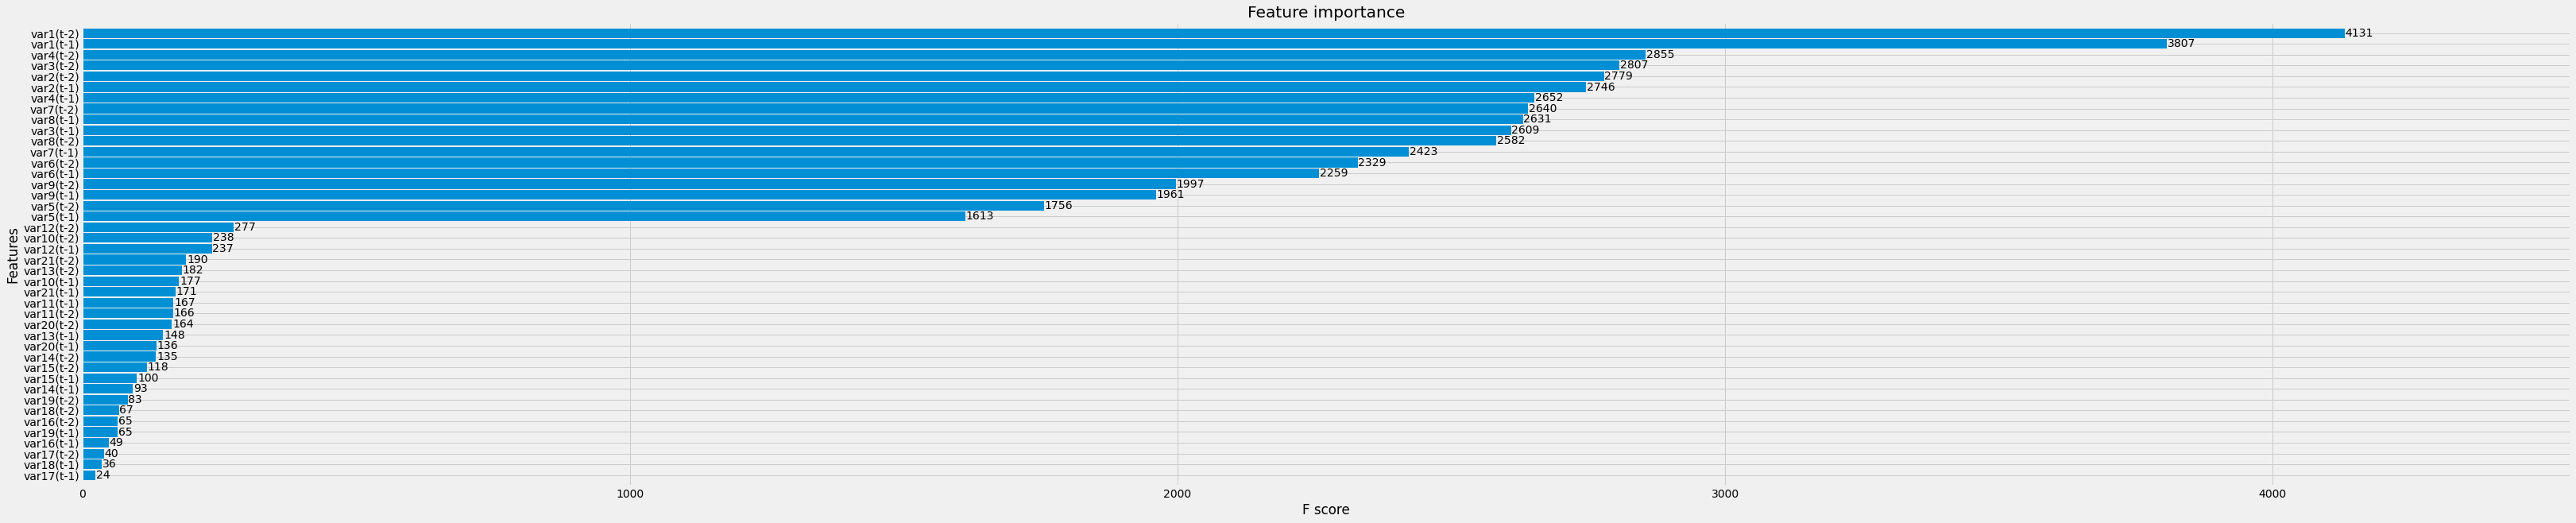

In [ ]:
plot_importance(reg, height=0.9)

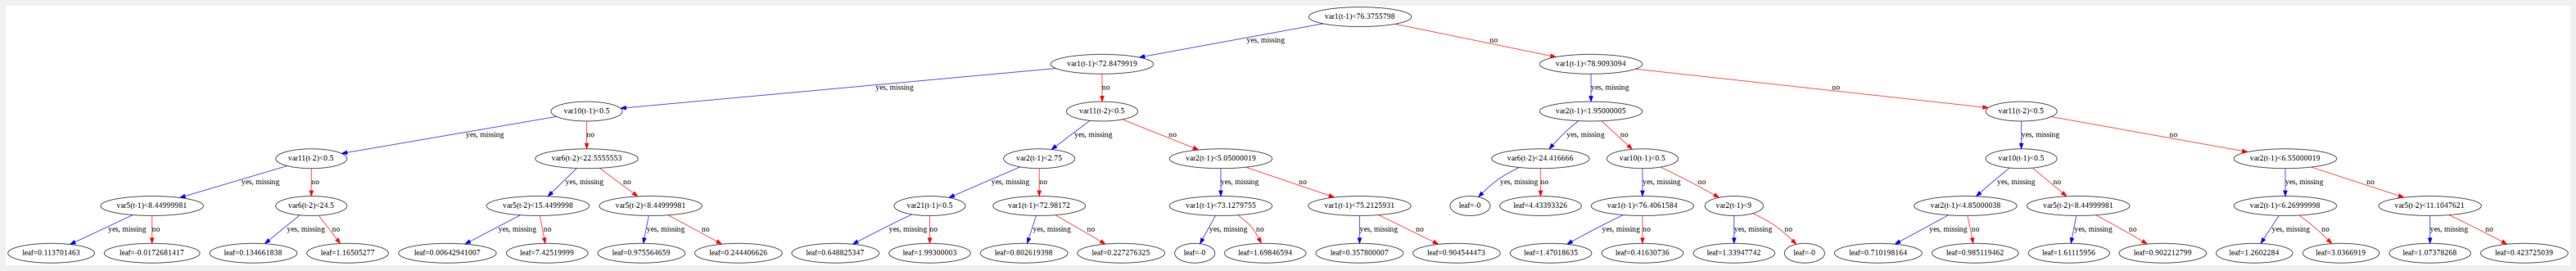

In [ ]:
import matplotlib.pyplot as plt

xgb.plot_tree(reg, num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()

In [ ]:
yhat = reg.predict(dvalid)
rmse = np.sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 14.304


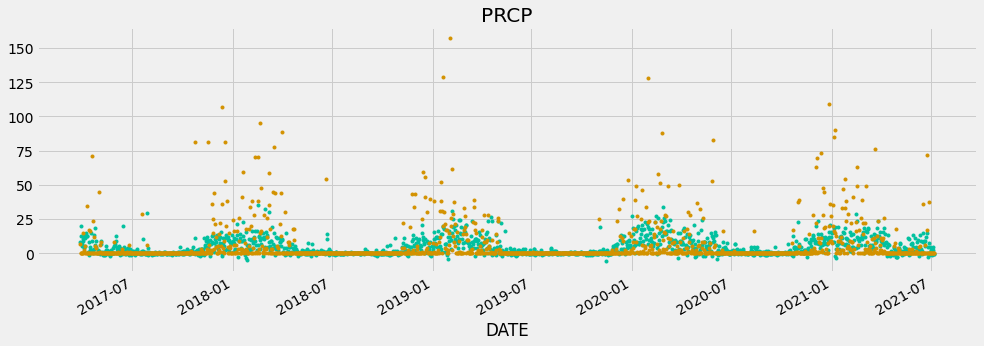

In [ ]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
hasil = pd.DataFrame({'Prediksi': yhat, 'Asli': test_y}, columns=['Prediksi', 'Asli'])
hasil['Prediksi'].plot(style='.', figsize=(15,5), color=color_pal[4], title='PRCP')
hasil['Asli'].plot(style='.', figsize=(15,5), color=color_pal[1])

In [ ]:
from IPython.core.display import HTML
display(HTML(hasil.to_html()))

,Prediksi,Asli
DATE,,
2017-03-27,7.914783,6.870095
2017-03-28,19.702402,0.000000
2017-03-29,12.785456,0.000000
2017-03-30,5.197109,0.000000
2017-03-31,6.779876,0.254000
2017-04-01,9.107978,0.000000
2017-04-02,10.502162,14.986000
2017-04-03,3.808459,2.286000
2017-04-04,12.778116,1.016000


#XGBClassifier

In [ ]:
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import preprocessing

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from pandas import DataFrame
from pandas import concat

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

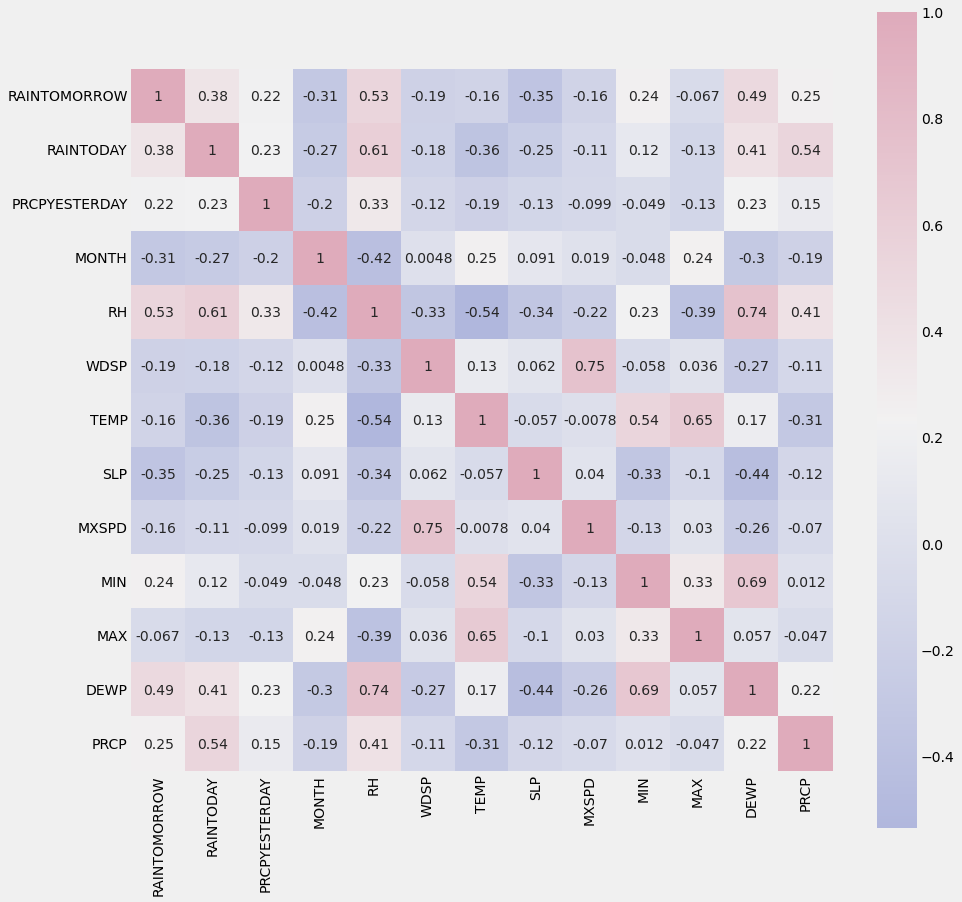

In [ ]:
# Correlation amongst numeric attributes
corrmat = df.corr()
cmap = sns.diverging_palette(260,-10,s=50, l=75, n=6, as_cmap=True)
plt.subplots(figsize=(14,14))
sns.heatmap(corrmat,cmap= cmap,annot=True, square=True)

In [ ]:
month = pd.get_dummies(df['MONTH'], prefix='MONTH')
df = df.join(month)
df.drop(columns=['MONTH'], inplace=True)
df.head()

,RAINTOMORROW,RAINTODAY,RH,WDSP,TEMP,SLP,MXSPD,MIN,MAX,DEWP,PRCP,MONTH_1,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12
DATE,,,,,,,,,,,,,,,,,,,,,,,
2000-01-01,1.0,0,75.404622,3.6,28.500000,1006.400000,9.9,23.888889,33.777778,23.833333,0.000000,1,0,0,0,0,0,0,0,0,0,0,0
2000-01-02,1.0,1,79.204324,4.5,27.277778,1009.010000,15.0,24.000000,33.000000,23.444444,5.948947,1,0,0,0,0,0,0,0,0,0,0,0
2000-01-03,1.0,1,81.816506,5.6,26.000000,1008.850000,8.9,23.000000,29.000000,22.722222,15.024100,1,0,0,0,0,0,0,0,0,0,0,0
2000-01-04,0.0,1,76.873187,2.8,27.833333,1008.852381,8.0,24.000000,31.000000,23.500000,11.817048,1,0,0,0,0,0,0,0,0,0,0,0
2000-01-05,0.0,0,77.225686,2.1,28.500000,1008.100000,6.0,24.388889,32.000000,24.222222,0.000000,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X = df.drop('RAINTOMORROW', axis=1)
Y = df['RAINTOMORROW']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=44)

In [ ]:
from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state=44)
X_sm, y_sm = sm.fit_resample(X_train, y_train)

print(f'''Shape of X before SMOTE: {fitur.shape}
Shape of X after SMOTE: {X_sm.shape}''')

Shape of X before SMOTE: (5455, 22)
Shape of X after SMOTE: (11283, 22)


In [ ]:
model = XGBClassifier()
model.fit(X_sm, y_sm)

XGBClassifier(objective='multi:softprob')

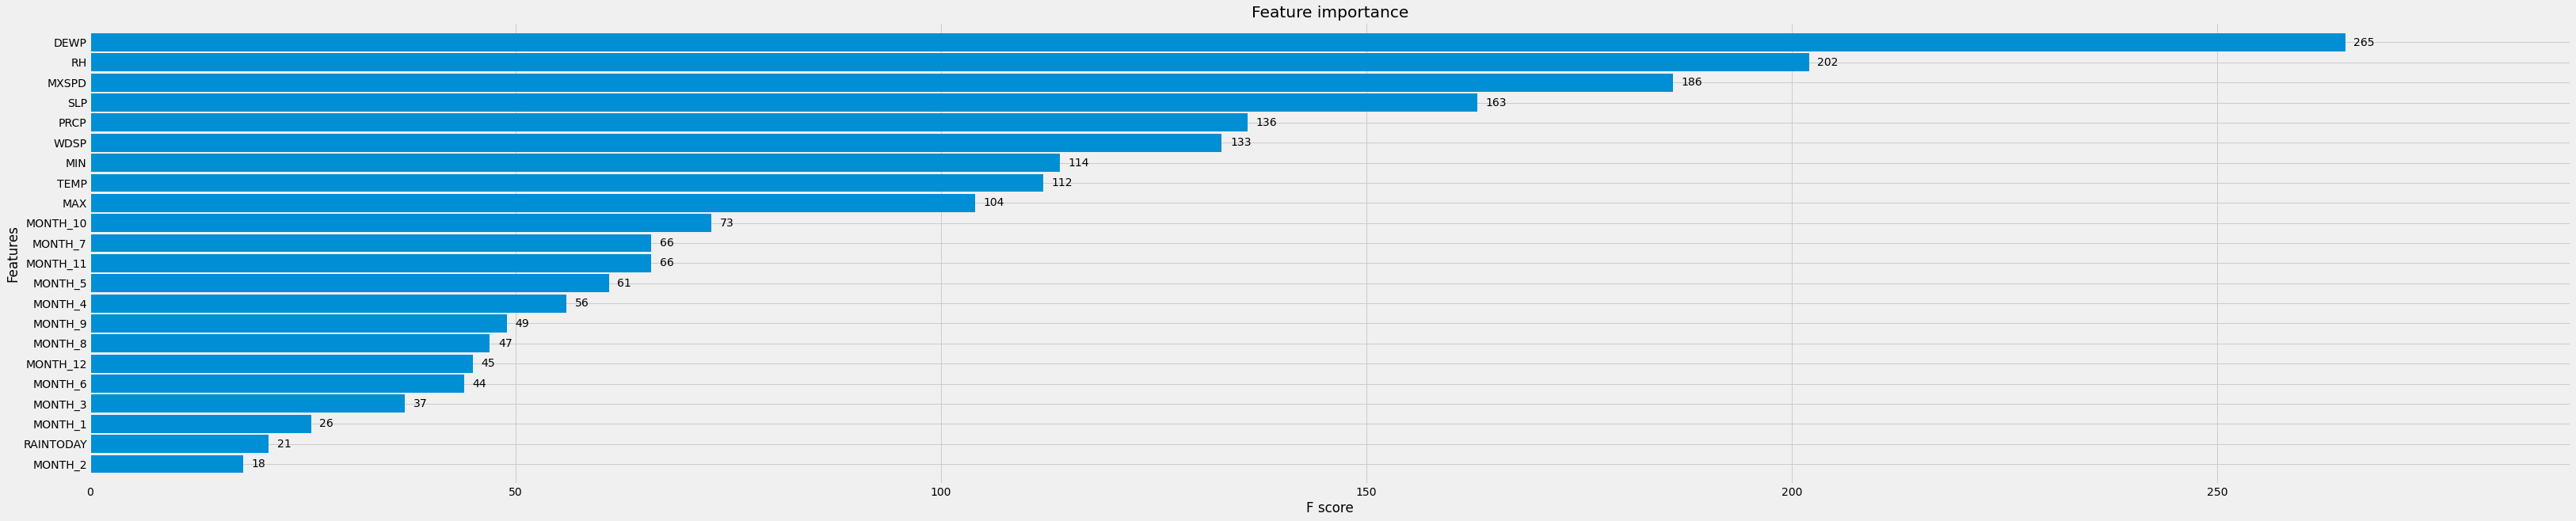

In [ ]:
plot_importance(model, height=0.9)

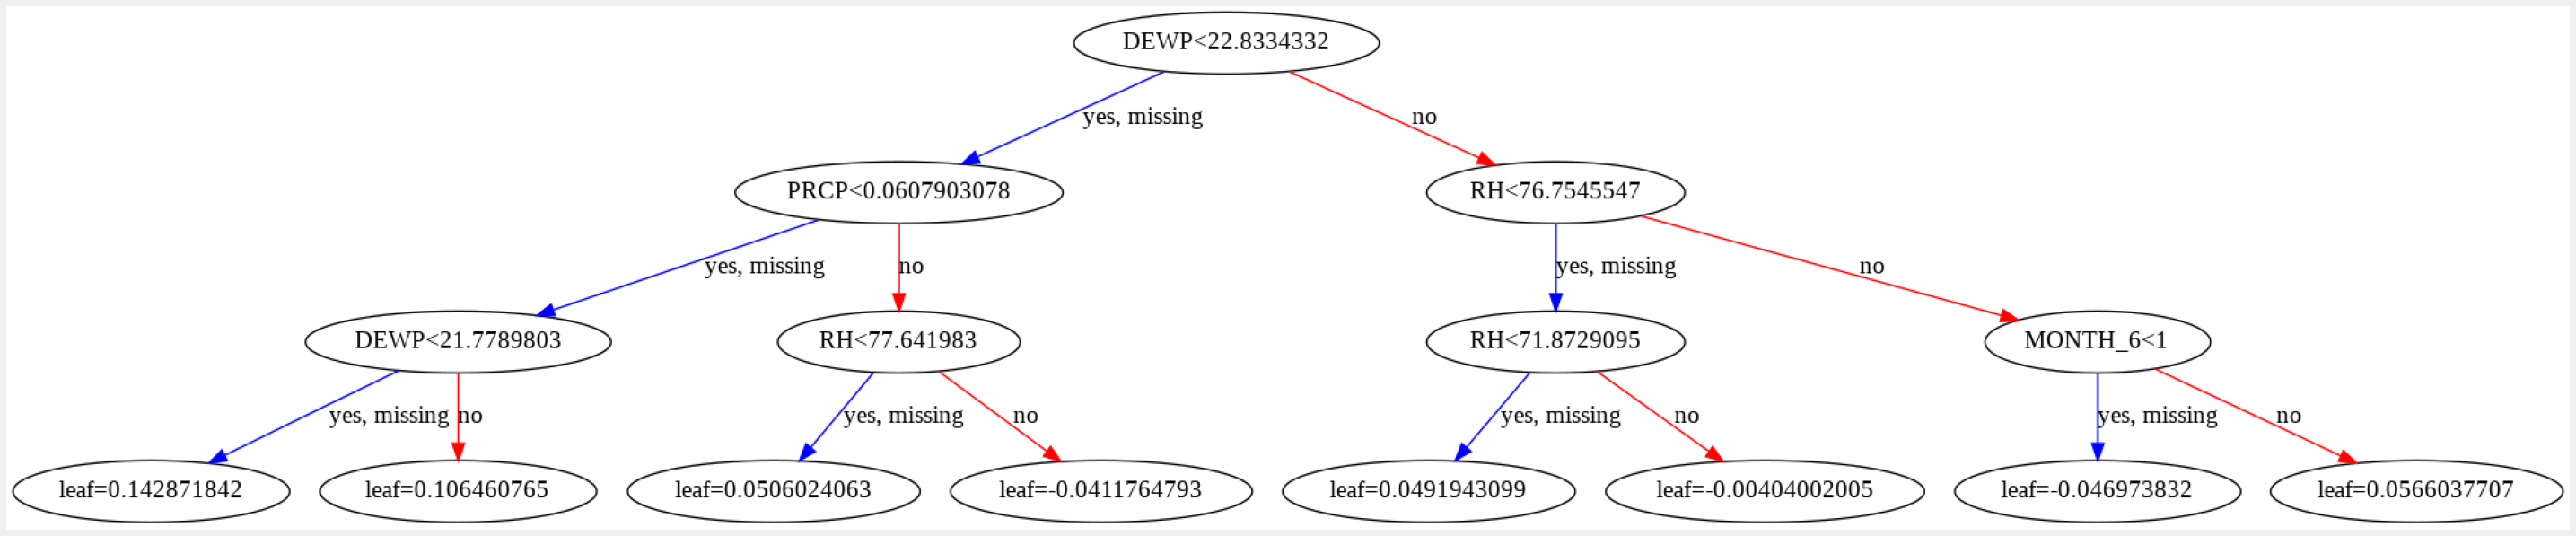

In [ ]:
import matplotlib.pyplot as plt

xgb.plot_tree(model, num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()

In [ ]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [ ]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 66.61%


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.90      0.75      0.82      1646
         1.0       0.41      0.51      0.45       514
         2.0       0.18      0.33      0.24       179

    accuracy                           0.67      2339
   macro avg       0.50      0.53      0.50      2339
weighted avg       0.74      0.67      0.69      2339



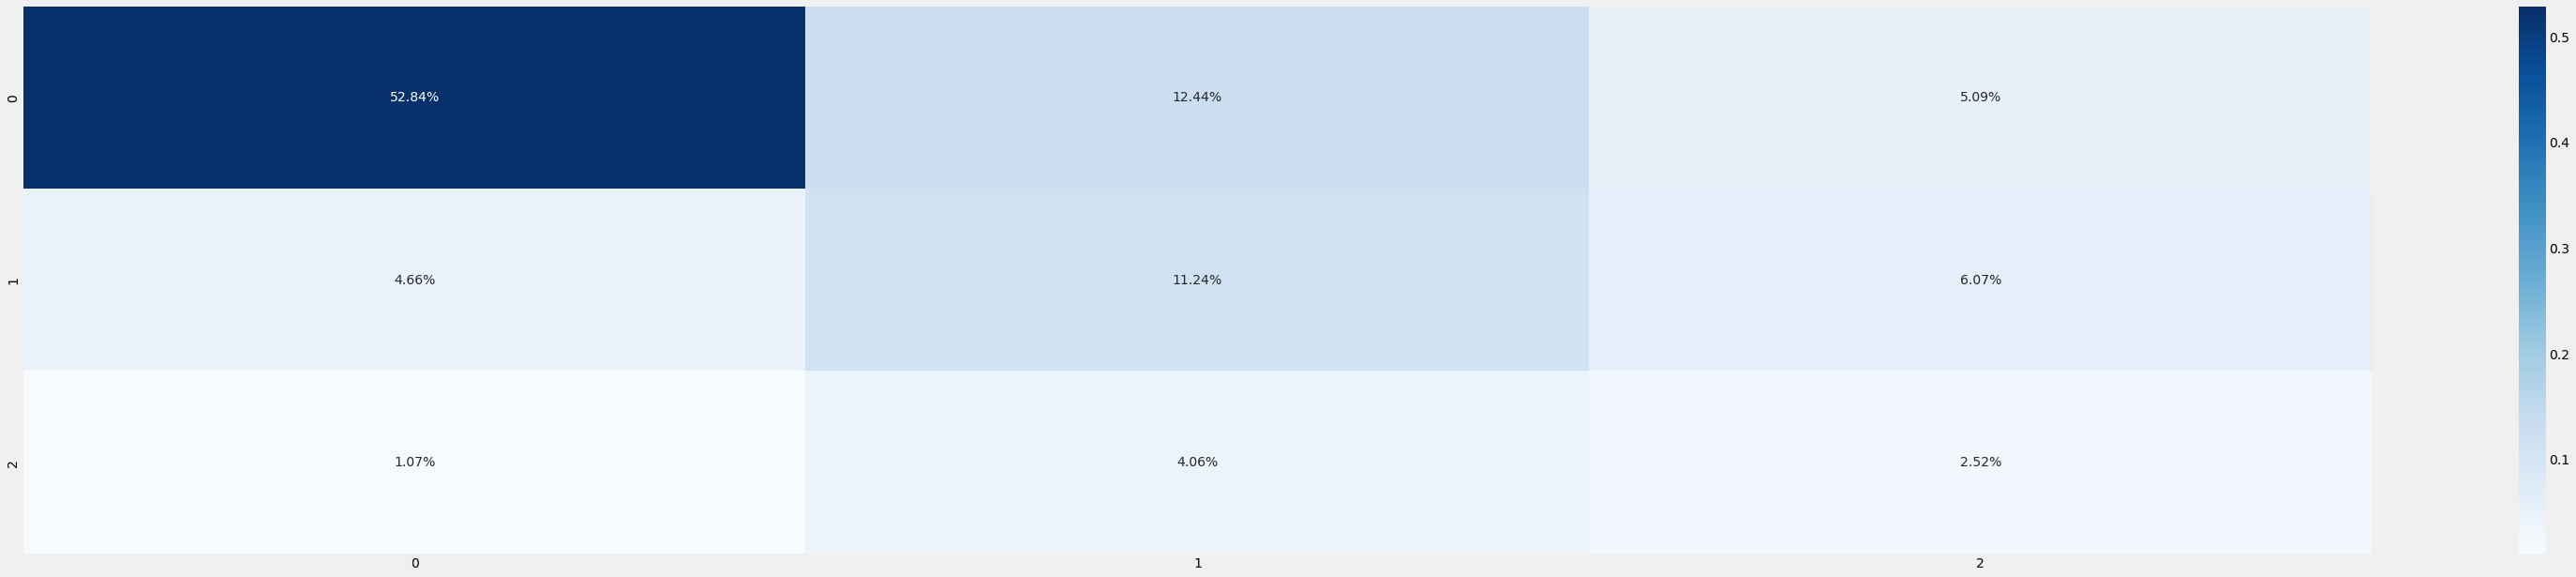

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, predictions)
# sns.heatmap(cf_matrix, annot=True)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

#Regresi Linear Multivariate

In [ ]:
df

,RH,WDSP,TEMP,SLP,MXSPD,MIN,MAX,DEWP,PRCP,MONTH_1,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12
DATE,,,,,,,,,,,,,,,,,,,,,
2000-01-01,75.404622,3.6,28.500000,1006.400000,9.9,23.888889,33.777778,23.833333,0.000000,1,0,0,0,0,0,0,0,0,0,0,0
2000-01-02,79.204324,4.5,27.277778,1009.010000,15.0,24.000000,33.000000,23.444444,5.948947,1,0,0,0,0,0,0,0,0,0,0,0
2000-01-03,81.816506,5.6,26.000000,1008.850000,8.9,23.000000,29.000000,22.722222,15.024100,1,0,0,0,0,0,0,0,0,0,0,0
2000-01-04,76.873187,2.8,27.833333,1008.852381,8.0,24.000000,31.000000,23.500000,11.817048,1,0,0,0,0,0,0,0,0,0,0,0
2000-01-05,77.225686,2.1,28.500000,1008.100000,6.0,24.388889,32.000000,24.222222,0.000000,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-03,77.334308,3.9,27.333333,1009.800000,6.0,24.000000,32.222222,23.111111,0.000000,0,0,0,0,0,0,1,0,0,0,0,0
2021-07-04,71.806090,5.4,28.055556,1010.000000,11.1,23.222222,32.222222,22.611111,0.000000,0,0,0,0,0,0,1,0,0,0,0,0
2021-07-05,70.977479,6.0,27.500000,1008.900000,15.9,23.777778,33.000000,21.888889,0.000000,0,0,0,0,0,0,1,0,0,0,0,0


In [ ]:
from sklearn.model_selection import train_test_split
# splitting the data
x = df.drop(['PRCP'], axis=1)
y = df['PRCP']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [ ]:
from sklearn.linear_model import LinearRegression
# creating an object of LinearRegression class
LR = LinearRegression()
# fitting the training data
LR.fit(x_train,y_train)

LinearRegression()

In [ ]:
y_prediction =  LR.predict(x_test)
y_prediction

array([ 4.69388929,  5.07535689, -0.58443099, ...,  8.95118329,
       -1.66054387, -1.51360185])

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_prediction))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 12.111


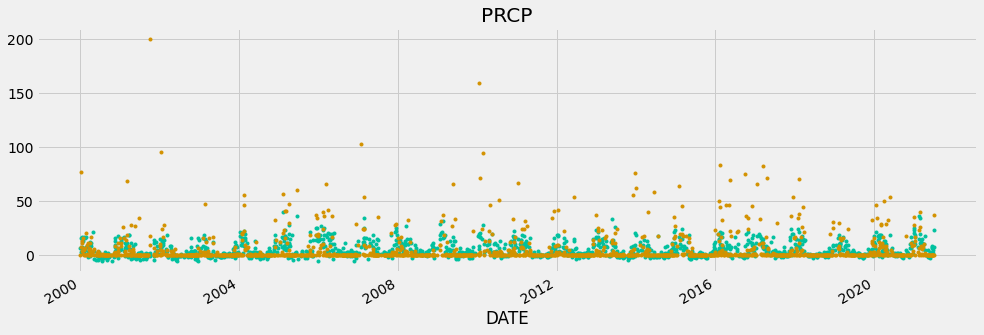

In [ ]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
hasil = pd.DataFrame({'Prediksi': y_prediction, 'Asli': y_test}, columns=['Prediksi', 'Asli'])
hasil['Prediksi'].plot(style='.', figsize=(15,5), color=color_pal[4], title='PRCP')
hasil['Asli'].plot(style='.', figsize=(15,5), color=color_pal[1])

In [ ]:
from IPython.core.display import HTML
display(HTML(hasil.to_html()))

,Prediksi,Asli
DATE,,
2008-02-21,4.693889,0.000000
2015-03-21,5.075357,0.762000
2007-10-27,-0.584431,0.000000
2002-10-23,0.673944,0.000000
2000-04-12,10.897887,16.002000
2018-07-29,-0.672316,0.000000
2001-05-19,9.625900,26.924000
2011-01-27,9.882872,0.000000
2010-03-29,9.329999,4.064000


##PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(x_train)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.74116012 0.14315599]
[623.14543941 273.86602213]


In [ ]:
X_pca = pca.transform(x_train)
X_pca.shape
#plt.figure(figsize=(8,6))
#plt.scatter(X_pca[:, 0],X_pca[:, 1])

(6236, 2)

In [ ]:
from sklearn.linear_model import LinearRegression
# creating an object of LinearRegression class
LR = LinearRegression()
# fitting the training data
LR.fit(X_pca,y_train)

LinearRegression()

In [ ]:
X_pcatest = pca.transform(x_test)
y_prediction =  LR.predict(X_pcatest)
y_prediction

array([ 7.20797503,  6.98599768, -1.03558549, ...,  8.03051534,
        2.01554734,  1.20316097])

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_prediction))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 12.705


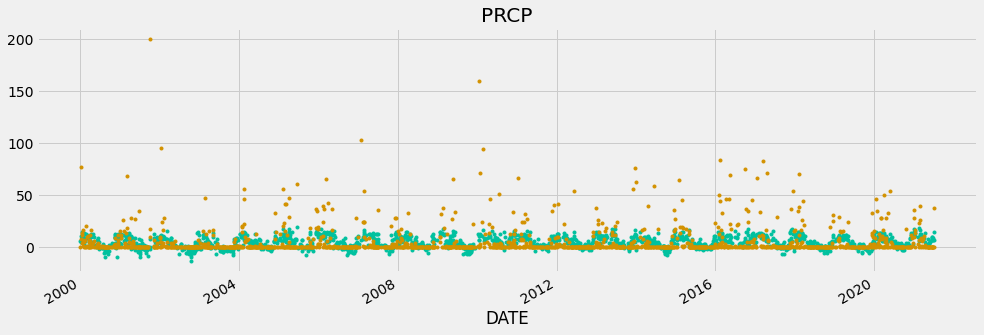

In [ ]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
hasil = pd.DataFrame({'Prediksi': y_prediction, 'Asli': y_test}, columns=['Prediksi', 'Asli'])
hasil['Prediksi'].plot(style='.', figsize=(15,5), color=color_pal[4], title='PRCP')
hasil['Asli'].plot(style='.', figsize=(15,5), color=color_pal[1])

In [ ]:
from IPython.core.display import HTML
display(HTML(hasil.to_html()))

,Prediksi,Asli
DATE,,
2008-02-21,7.207975,0.000000
2015-03-21,6.985998,0.762000
2007-10-27,-1.035585,0.000000
2002-10-23,-4.749504,0.000000
2000-04-12,11.902728,16.002000
2018-07-29,-1.038905,0.000000
2001-05-19,8.145681,26.924000
2011-01-27,8.400492,0.000000
2010-03-29,8.112774,4.064000


#ARIMA

In [ ]:
# evaluate an ARIMA model using a walk-forward validation
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df.head()

,RH,WDSP,TEMP,SLP,MXSPD,MIN,MAX,DEWP,PRCP,MONTH_1,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,RAINT_0,RAINT_1,RAINT_2
DATE,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-01,75.404622,3.6,28.500000,1006.400000,9.9,23.888889,33.777778,23.833333,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2000-01-02,79.204324,4.5,27.277778,1009.010000,15.0,24.000000,33.000000,23.444444,5.948947,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2000-01-03,81.816506,5.6,26.000000,1008.850000,8.9,23.000000,29.000000,22.722222,15.024100,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2000-01-04,76.873187,2.8,27.833333,1008.852381,8.0,24.000000,31.000000,23.500000,11.817048,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2000-01-05,77.225686,2.1,28.500000,1008.100000,6.0,24.388889,32.000000,24.222222,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
# split into train and test sets
X = df[['RH']].values
size = int(len(X) * 0.8)
train, test = X[(size-14):size], X[size:len(X)]
history = [x for x in train]
predictions = list()

In [ ]:
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=83.321231, expected=78.162467


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predicted=81.897003, expected=90.041779


LinAlgError: ignored

Test RMSE: 4.047


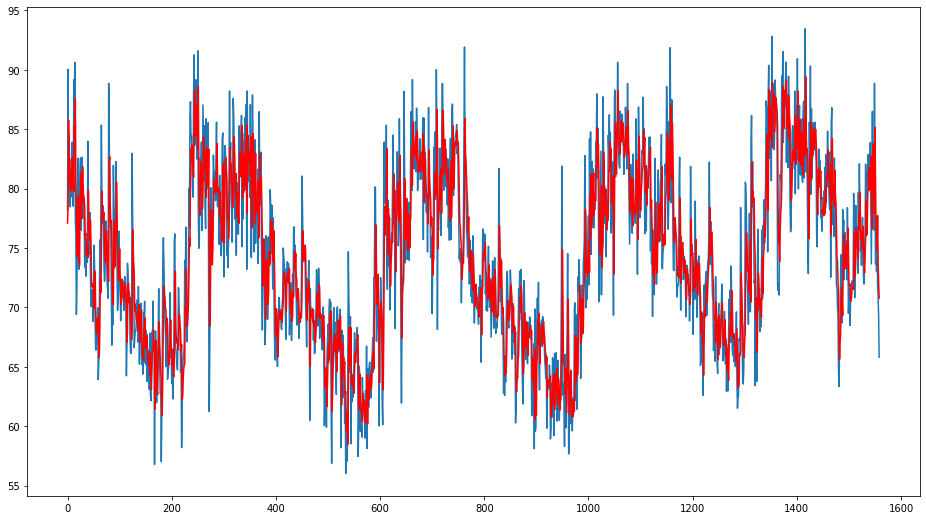

In [ ]:
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [ ]:
predictions = list()

In [ ]:
# walk-forward validation
history = [x for x in train]
for t in range(10):
  output = model_fit.forecast()
  yhat = output[0]
  predictions.append(yhat)
  history.append(yhat)
  print('predicted=%f' % (yhat))

predicted=70.783933
predicted=70.783933
predicted=70.783933
predicted=70.783933
predicted=70.783933
predicted=70.783933
predicted=70.783933
predicted=70.783933
predicted=70.783933
predicted=70.783933


In [ ]:
a = np.array([1,2,3,4,5])
b = np.array([2,3,4,5,6])
rmse = sqrt(mean_squared_error(a, b))
print('RMSE: %.3f' % rmse)

RMSE: 1.000
